In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best parameters: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Logistic Regression Classifier Results:
Accuracy: 0.8291713961407492

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.05      0.10        79
           1       0.99      1.00      1.00       545
           2       0.76      0.99      0.86       894
           3       0.08      0.02      0.03        56
           4       0.78      0.31      0.45        93
           5       0.00      0.00      0.00        28
           6       0.00      0.00      0.00        67

    accuracy                           0.83      1762
   macro avg       0.49      0.34      0.35      1762
weighted avg       0.77      0.83      0.77      1762

Average Precision: 0.48812720560574274
Average Recall: 0.33812788463526416
Average F1 Score: 0.3467545474565092


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

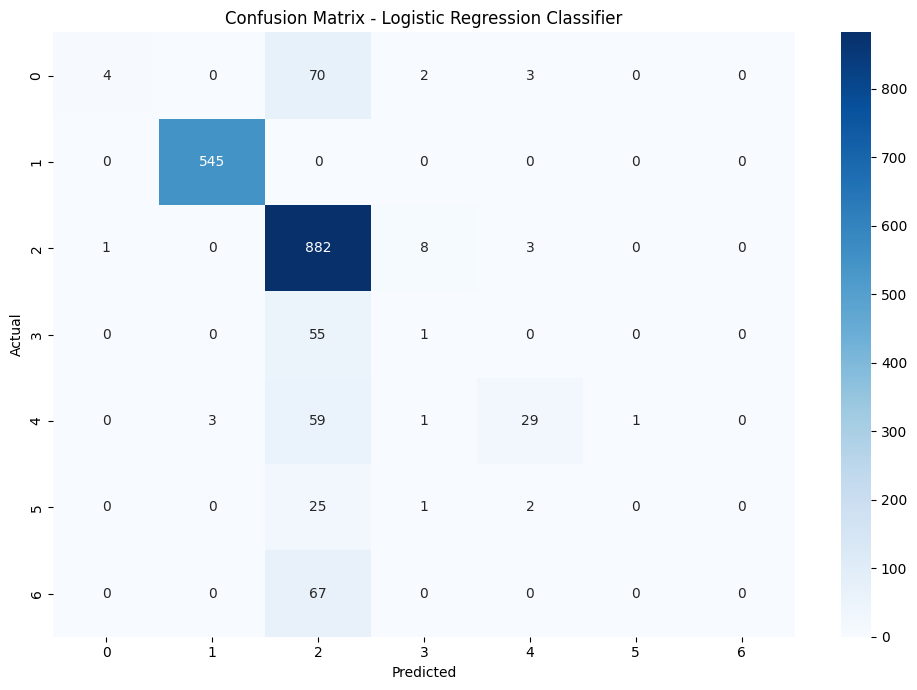

Cross-validation scores: [0.88857346 0.88360539 0.88786373 0.88857346 0.88786373]
Mean cross-validation accuracy: 0.8872959545777146


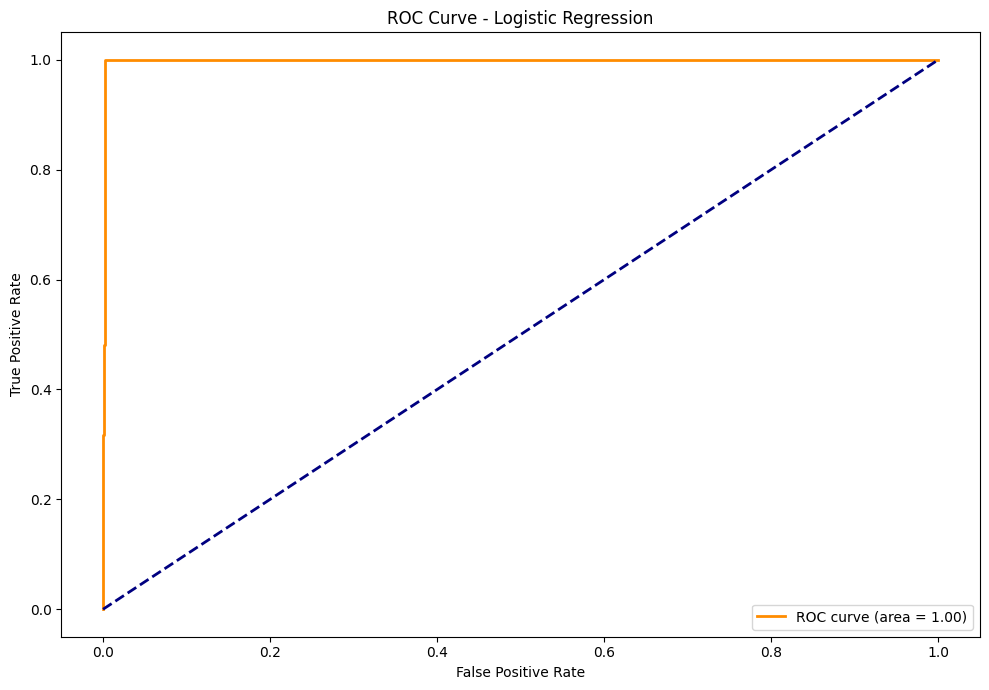

In [ ]:
#logistic regression with hyperparameter turning
!pip install category_encoders
import pandas as pd
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.model_selection import cross_val_score

# Downloading the needed resources
nltk.download('punkt')
nltk.download('stopwords')

# Loading the Netflix dataset
data = pd.read_csv('/content/drive/MyDrive/ML/netflix_titles.csv')

# Group genres into broader categories because each genre is classified into more then one genre
#now the genres are classified as the first genre
def group_genres(genre_str):
    genre_mappings = {
        'TV Shows': ['TV', 'Docuseries', 'Reality TV'],
        'Movies': ['Movies', 'Independent', 'Cult', 'Classic'],
        'Action': ['Action & Adventure'],
        'Drama': ['Dramas'],
        'Comedy': ['Comedies'],
        'Documentary': ['Documentaries']
    }
    if pd.isna(genre_str):
        return 'Other'
    for main_genre, sub_genres in genre_mappings.items():
        if any(sub in genre_str for sub in sub_genres):
            return main_genre
    return 'Other'

# grouping the genres and adding separate column
data['grouped_genre'] = data['genre'].apply(group_genres)


# Mapping the genres to numerical values, so we can easily group them
genre_mapping = {genre: idx for idx, genre in enumerate(data['grouped_genre'].unique())}
data['group_num_genre'] = data['grouped_genre'].map(genre_mapping)

# Defining the features and target, y hat is the genre, using these features
features = ['type', 'title', 'director', 'cast', 'country', 'rating', 'duration', 'description']
X = data[features]
# using the group number of the genre
y = data['group_num_genre']

# Check for NaN values and drop them if needed
# this step helps to avaoid NAN value interpretation
X = X[y.notna()]
y = y[y.notna()]

# Making sure y is a Pandas Series-this step helps us to hold any data type on y
y = pd.Series(y, name='group_num_genre')

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating a TargetEncoder for categorical features (excluding 'grouped_genre'),
#because we already grouped the grouped_genre
encoder = ce.TargetEncoder(cols=['type', 'title', 'director', 'cast', 'country', 'rating', 'duration'])

# making sure categorical features are extracted properly (excluding 'grouped_genre' as it's already the target)
X_train_cat = X_train[['type', 'title', 'director', 'cast', 'country', 'rating', 'duration']]
X_test_cat = X_test[['type', 'title', 'director', 'cast', 'country', 'rating', 'duration']]

# Reseting for both training and test sets to ensure alignment-because dropping need to be done for the entire row.
X_train_cat.reset_index(drop=True, inplace=True)
X_test_cat.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

# making sure y_train is still a Series
assert isinstance(y_train, pd.Series), "y_train is not a Pandas Series."

# Converting  X_train_cat and X_test_cat to DataFrames explicitly before encoding
X_train_cat = pd.DataFrame(X_train_cat, columns=['type', 'title', 'director', 'cast', 'country', 'rating', 'duration'])
X_test_cat = pd.DataFrame(X_test_cat, columns=['type', 'title', 'director', 'cast', 'country', 'rating', 'duration'])

# Fitting the transformed categorical features
X_train_cat_encoded = encoder.fit_transform(X_train_cat, y_train)
X_test_cat_encoded = encoder.transform(X_test_cat)

# Creating a CountVectorizer for text features
vectorizer = CountVectorizer()

# Fitting and transforming the 'description' column in the training data
X_train_desc_vec = vectorizer.fit_transform(X_train['description'])
X_test_desc_vec = vectorizer.transform(X_test['description'])

# Combining the vectorized text features and encoded categorical features
X_train_combined = pd.concat([pd.DataFrame(X_train_desc_vec.toarray()), X_train_cat_encoded.reset_index(drop=True)], axis=1)
X_test_combined = pd.concat([pd.DataFrame(X_test_desc_vec.toarray()), X_test_cat_encoded.reset_index(drop=True)], axis=1)

# Converting the column names to strings to ensure compatibility
X_train_combined.columns = X_train_combined.columns.astype(str)
X_test_combined.columns = X_test_combined.columns.astype(str)

# Standardizing the features
scaler = StandardScaler()
X_train_final = scaler.fit_transform(X_train_combined)
X_test_final = scaler.transform(X_test_combined)

# Initializing the Logistic Regression model with hyperparameter tuning
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']  # solver compatible with l1 penalty
}
# Performing grid search with cross-validation
log_reg = GridSearchCV(LogisticRegression(random_state=42), param_grid, cv=3, n_jobs=-1, verbose=2)

# Training the model using the combined features
log_reg.fit(X_train_final, y_train)

# Best parameters from GridSearch
print(f"Best parameters: {log_reg.best_params_}")

# Make predictions on the test set using the combined test features
y_pred = log_reg.predict(X_test_final)

# Evaluate the model
print("Logistic Regression Classifier Results:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Calculate average precision, recall, and F1 score
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')

print("Average Precision:", precision)
print("Average Recall:", recall)
print("Average F1 Score:", f1)

# Confusion Matrix
plt.figure(figsize=(10, 7))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Logistic Regression Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()



In [ ]:
!pip install category_encoders
import pandas as pd
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
# downloading the needed resource
nltk.download('punkt_tab')
nltk.download('stopwords')
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.model_selection import cross_val_score

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# SVM with hyperparameter tuning

!pip install category_encoders
import pandas as pd
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.svm import SVC
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce

# Downloading the needed resources
nltk.download('punkt')
nltk.download('stopwords')

# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/ML/netflix_titles.csv')

# Group genres into broader categories
def group_genres(genre_str):
    genre_mappings = {
        'TV Shows': ['TV', 'Docuseries', 'Reality TV'],
        'Movies': ['Movies', 'Independent', 'Cult', 'Classic'],
        'Action': ['Action & Adventure'],
        'Drama': ['Dramas'],
        'Comedy': ['Comedies'],
        'Documentary': ['Documentaries']
    }
    if pd.isna(genre_str):
        return 'Other'
    for main_genre, sub_genres in genre_mappings.items():
        if any(sub in genre_str for sub in sub_genres):
            return main_genre
    return 'Other'

# Apply genre grouping and add a column
data['grouped_genre'] = data['genre'].apply(group_genres)

# Map genres to numerical values
genre_mapping = {genre: idx for idx, genre in enumerate(data['grouped_genre'].unique())}
data['group_num_genre'] = data['grouped_genre'].map(genre_mapping)

# Define features and target
features = ['type', 'title', 'director', 'cast', 'country', 'rating', 'duration', 'description']
X = data[features]
y = data['group_num_genre']

# Check for NaN values and drop them if needed
X = X[y.notna()]
y = y[y.notna()]

# Ensure y is a Pandas Series
y = pd.Series(y, name='group_num_genre')

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a TargetEncoder for categorical features (excluding 'grouped_genre')
encoder = ce.TargetEncoder(cols=['type', 'title', 'director', 'cast', 'country', 'rating', 'duration'])

# Ensure categorical features are extracted properly (excluding 'grouped_genre' as it's already the target)
X_train_cat = X_train[['type', 'title', 'director', 'cast', 'country', 'rating', 'duration']]
X_test_cat = X_test[['type', 'title', 'director', 'cast', 'country', 'rating', 'duration']]

# Reset indices for both training and test sets to ensure alignment
X_train_cat.reset_index(drop=True, inplace=True)
X_test_cat.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

# Ensure y_train is still a Series
assert isinstance(y_train, pd.Series), "y_train is not a Pandas Series."

# Convert X_train_cat and X_test_cat to DataFrames explicitly before encoding
X_train_cat = pd.DataFrame(X_train_cat, columns=['type', 'title', 'director', 'cast', 'country', 'rating', 'duration'])
X_test_cat = pd.DataFrame(X_test_cat, columns=['type', 'title', 'director', 'cast', 'country', 'rating', 'duration'])

# Fit and transform the categorical features
X_train_cat_encoded = encoder.fit_transform(X_train_cat, y_train)
X_test_cat_encoded = encoder.transform(X_test_cat)

# Create a CountVectorizer for text features
vectorizer = CountVectorizer()

# Fit and transform the 'description' column in the training data
X_train_desc_vec = vectorizer.fit_transform(X_train['description'])
X_test_desc_vec = vectorizer.transform(X_test['description'])

# Combine the vectorized text features and encoded categorical features
X_train_combined = pd.concat([pd.DataFrame(X_train_desc_vec.toarray()), X_train_cat_encoded.reset_index(drop=True)], axis=1)
X_test_combined = pd.concat([pd.DataFrame(X_test_desc_vec.toarray()), X_test_cat_encoded.reset_index(drop=True)], axis=1)

# Convert column names to strings to ensure compatibility
X_train_combined.columns = X_train_combined.columns.astype(str)
X_test_combined.columns = X_test_combined.columns.astype(str)

# Define the SVM model with hyperparameter tuning
param_grid_svm = {
    'C': [0.01, 0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

# Perform grid search with cross-validation
svm_model = GridSearchCV(SVC(probability=True, random_state=42), param_grid_svm, cv=3, n_jobs=-1, verbose=2)

# Train the SVM model using the combined features
svm_model.fit(X_train_combined, y_train)

# Best parameters from GridSearch
print(f"Best parameters for SVM: {svm_model.best_params_}")

# Make predictions on the test set using the combined test features
y_pred = svm_model.predict(X_test_combined)

# Evaluate the model
print("SVM Classifier Results:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Calculate average precision, recall, and F1 score
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')

print("Average Precision:", precision)
print("Average Recall:", recall)
print("Average F1 Score:", f1)

# Confusion Matrix
plt.figure(figsize=(10, 7))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - SVM Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# Plotting Decision Boundaries using PCA for 2D Visualization
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_combined)
X_test_pca = pca.transform(X_test_combined)

# Train again on PCA-reduced data for visualization
svm_clf_pca = SVC(probability=True, random_state=42)
svm_clf_pca.fit(X_train_pca, y_train)

# Plot decision boundaries
plt.figure(figsize=(10, 7))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='viridis', s=5)
plt.title('SVM Decision Boundaries with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Fitting 3 folds for each of 16 candidates, totalling 48 fits


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 2.3 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


SVM Classifier Results:
Accuracy: 0.8450624290578888

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.11      0.20        79
           1       0.99      1.00      1.00       545
           2       0.77      1.00      0.87       894
           3       0.00      0.00      0.00        56
           4       0.95      0.45      0.61        93
           5       0.00      0.00      0.00        28
           6       1.00      0.03      0.06        67

    accuracy                           0.85      1762
   macro avg       0.64      0.37      0.39      1762
weighted avg       0.82      0.85      0.79      1762

Average Precision: 0.6385474639522073
Average Recall: 0.37029028506134115
Average F1 Score: 0.3907764931227848


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

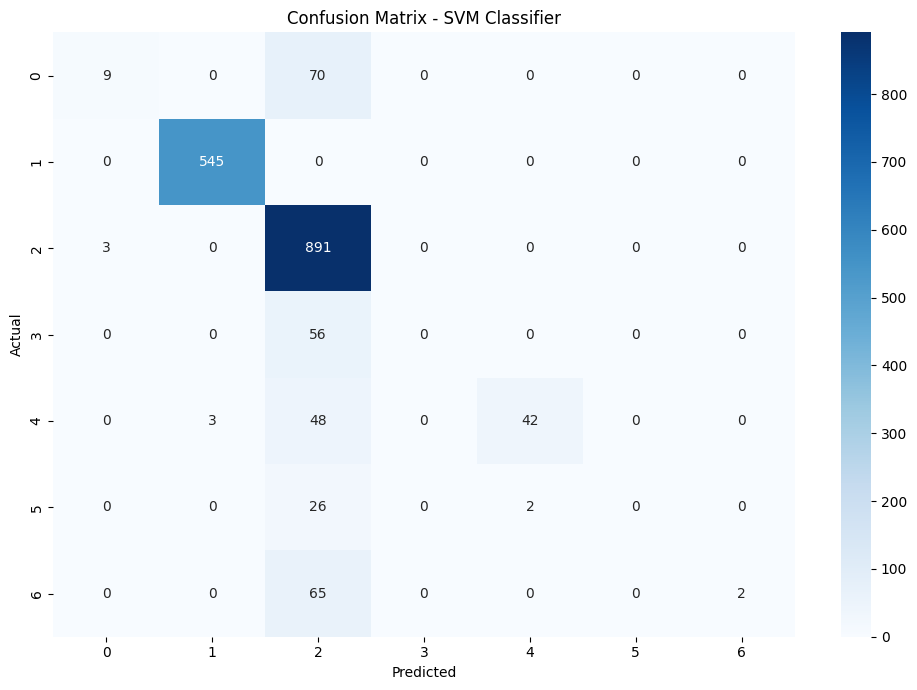

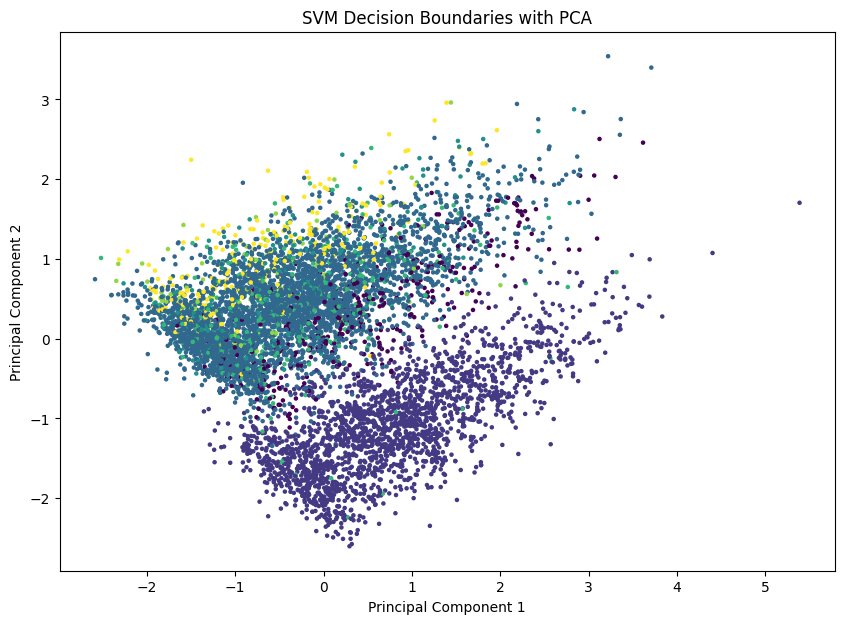

In [2]:
# SVM without hyperparameter tuning
!pip install category_encoders
import pandas as pd
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.svm import SVC
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce

# Downloading the needed resources
nltk.download('punkt')
nltk.download('stopwords')

# Loading the Netflix dataset
data = pd.read_csv('/content/drive/MyDrive/ML/netflix_titles.csv')

# Group genres into broader categories because each genre is classified into more then one genre
#now the genres are classified as the first genre
def group_genres(genre_str):
    genre_mappings = {
        'TV Shows': ['TV', 'Docuseries', 'Reality TV'],
        'Movies': ['Movies', 'Independent', 'Cult', 'Classic'],
        'Action': ['Action & Adventure'],
        'Drama': ['Dramas'],
        'Comedy': ['Comedies'],
        'Documentary': ['Documentaries']
    }
    if pd.isna(genre_str):
        return 'Other'
    for main_genre, sub_genres in genre_mappings.items():
        if any(sub in genre_str for sub in sub_genres):
            return main_genre
    return 'Other'

# grouping the genres and adding separate column
data['grouped_genre'] = data['genre'].apply(group_genres)

# Mapping the genres to numerical values, so we can easily group them
genre_mapping = {genre: idx for idx, genre in enumerate(data['grouped_genre'].unique())}
data['group_num_genre'] = data['grouped_genre'].map(genre_mapping)

# Defining the features and target, y hat is the genre, using these features
features = ['type', 'title', 'director', 'cast', 'country', 'rating', 'duration', 'description']
X = data[features]
y = data['group_num_genre']

# Checking for NaN values and drop them if needed
# this step helps to avaoid NAN value interpretation
X = X[y.notna()]
y = y[y.notna()]

# Making sure y is a Pandas Series-this step helps us to hold any data type on y
y = pd.Series(y, name='group_num_genre')

# Spliting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating  a TargetEncoder for categorical features (excluding 'grouped_genre')
encoder = ce.TargetEncoder(cols=['type', 'title', 'director', 'cast', 'country', 'rating', 'duration'])

#making sure categorical features are extracted properly (excluding 'grouped_genre' as it's already the target)
X_train_cat = X_train[['type', 'title', 'director', 'cast', 'country', 'rating', 'duration']]
X_test_cat = X_test[['type', 'title', 'director', 'cast', 'country', 'rating', 'duration']]

# Reseting indices for both training and test sets to ensure alignment
X_train_cat.reset_index(drop=True, inplace=True)
X_test_cat.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

# making y_train is still a Series
assert isinstance(y_train, pd.Series), "y_train is not a Pandas Series."

# Converting the X_train_cat and X_test_cat to DataFrames explicitly before encoding
X_train_cat = pd.DataFrame(X_train_cat, columns=['type', 'title', 'director', 'cast', 'country', 'rating', 'duration'])
X_test_cat = pd.DataFrame(X_test_cat, columns=['type', 'title', 'director', 'cast', 'country', 'rating', 'duration'])

# Fiting and transform the categorical features
X_train_cat_encoded = encoder.fit_transform(X_train_cat, y_train)
X_test_cat_encoded = encoder.transform(X_test_cat)

# Creating a CountVectorizer for text features
vectorizer = CountVectorizer()

# Fitting and transform the 'description' column in the training data
X_train_desc_vec = vectorizer.fit_transform(X_train['description'])
X_test_desc_vec = vectorizer.transform(X_test['description'])

# Combining the vectorized text features and encoded categorical features
X_train_combined = pd.concat([pd.DataFrame(X_train_desc_vec.toarray()), X_train_cat_encoded.reset_index(drop=True)], axis=1)
X_test_combined = pd.concat([pd.DataFrame(X_test_desc_vec.toarray()), X_test_cat_encoded.reset_index(drop=True)], axis=1)

# Converting column names to strings to ensure compatibility
X_train_combined.columns = X_train_combined.columns.astype(str)
X_test_combined.columns = X_test_combined.columns.astype(str)

# Initializing the SVM Classifier
svm_clf = SVC(probability=True, random_state=42)

ing# Train the model using the combined features
svm_clf.fit(X_train_combined, y_train)

# Making the predictions on the test set using the combined test features
y_pred = svm_clf.predict(X_test_combined)

# Evaluating the model
print("SVM Classifier Results:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Calculating average precision, recall, and F1 score
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')

print("Average Precision:", precision)
print("Average Recall:", recall)
print("Average F1 Score:", f1)

# Confusion Matrix
plt.figure(figsize=(10, 7))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - SVM Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# Plotting Decision Boundaries using PCA for 2D Visualization
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_combined)
X_test_pca = pca.transform(X_test_combined)

# Train again on PCA-reduced data for visualization
svm_clf_pca = SVC(probability=True, random_state=42)
svm_clf_pca.fit(X_train_pca, y_train)

# Plot decision boundaries
plt.figure(figsize=(10, 7))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='viridis', s=5)
plt.title('SVM Decision Boundaries with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


SVM Classifier Results:
Accuracy: 0.8450624290578888

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.11      0.20        79
           1       0.99      1.00      1.00       545
           2       0.77      1.00      0.87       894
           3       0.00      0.00      0.00        56
           4       0.95      0.45      0.61        93
           5       0.00      0.00      0.00        28
           6       1.00      0.03      0.06        67

    accuracy                           0.85      1762
   macro avg       0.64      0.37      0.39      1762
weighted avg       0.82      0.85      0.79      1762



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


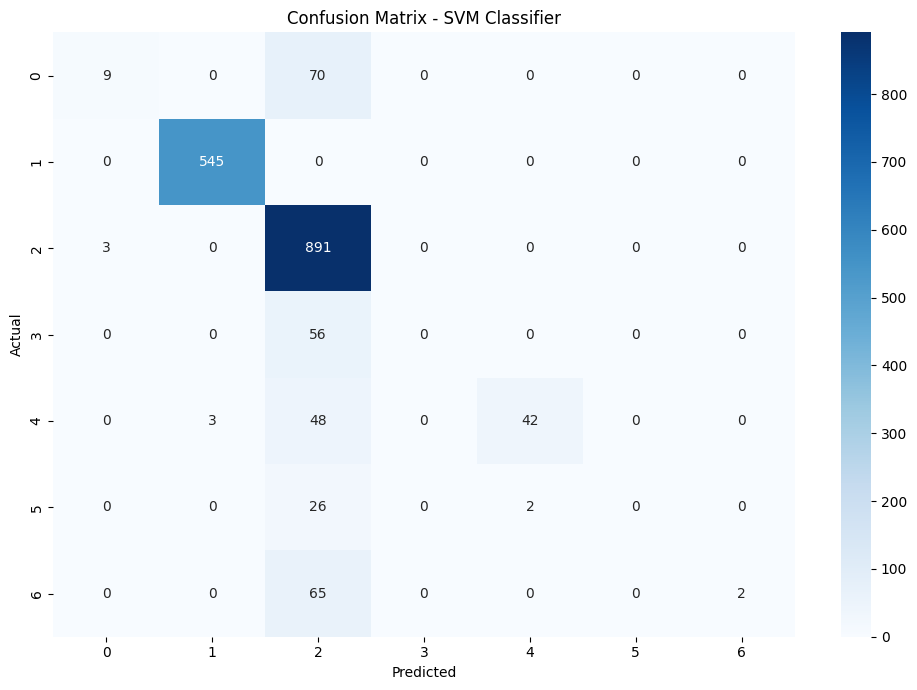

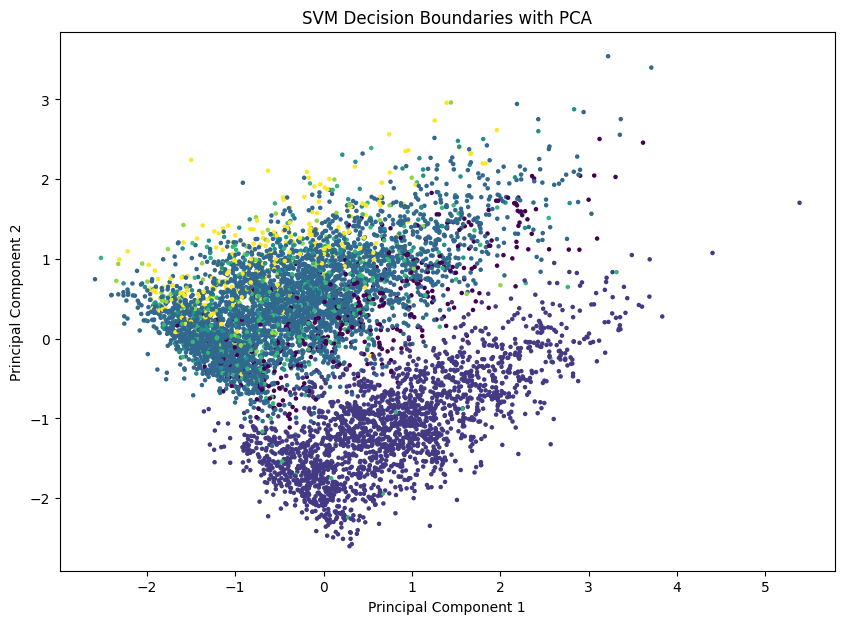

In [ ]:
#SVM without  hyperparameter tuning
!pip install category_encoders
import pandas as pd
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.model_selection import cross_val_score

# Downloading the needed resources
nltk.download('punkt')
nltk.download('stopwords')

# Loading the Netflix dataset
data = pd.read_csv('/content/drive/MyDrive/ML/netflix_titles.csv')

# Group genres into broader categories because each genre is classified into more then one genre
def group_genres(genre_str):
    genre_mappings = {
        'TV Shows': ['TV', 'Docuseries', 'Reality TV'],
        'Movies': ['Movies', 'Independent', 'Cult', 'Classic'],
        'Action': ['Action & Adventure'],
        'Drama': ['Dramas'],
        'Comedy': ['Comedies'],
        'Documentary': ['Documentaries']
    }
    if pd.isna(genre_str):
        return 'Other'
    for main_genre, sub_genres in genre_mappings.items():
        if any(sub in genre_str for sub in sub_genres):
            return main_genre
    return 'Other'

# grouping the genres and adding separate column
data['grouped_genre'] = data['genre'].apply(group_genres)

# Mapping the genres to numerical values, so we can easily group them
genre_mapping = {genre: idx for idx, genre in enumerate(data['grouped_genre'].unique())}
data['group_num_genre'] = data['grouped_genre'].map(genre_mapping)

# Defining the features and target, y hat is the genre-which we are predicting, using these features
features = ['type', 'title', 'director', 'cast', 'country', 'rating', 'duration', 'description']
X = data[features]
y = data['group_num_genre']

# Check for NaN values and drop them if needed
X = X[y.notna()]
y = y[y.notna()]

# Making sure y is a Pandas Series-this step helps us to hold any data type on y
y = pd.Series(y, name='group_num_genre')

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating a TargetEncoder for categorical features (excluding 'grouped_genre'),
#because we already grouped the grouped_genre
encoder = ce.TargetEncoder(cols=['type', 'title', 'director', 'cast', 'country', 'rating', 'duration'])

# making sure categorical features are extracted properly (excluding 'grouped_genre' as it's already the target)
X_train_cat = X_train[['type', 'title', 'director', 'cast', 'country', 'rating', 'duration']]
X_test_cat = X_test[['type', 'title', 'director', 'cast', 'country', 'rating', 'duration']]

# Reseting for both training and test sets to ensure alignment-because dropping need to be done for the entire row.
X_train_cat.reset_index(drop=True, inplace=True)
X_test_cat.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

# making sure y_train is still a Series
assert isinstance(y_train, pd.Series), "y_train is not a Pandas Series."

# Converting  X_train_cat and X_test_cat to DataFrames explicitly before encoding
X_train_cat = pd.DataFrame(X_train_cat, columns=['type', 'title', 'director', 'cast', 'country', 'rating', 'duration'])
X_test_cat = pd.DataFrame(X_test_cat, columns=['type', 'title', 'director', 'cast', 'country', 'rating', 'duration'])

# Fitting the transformed categorical features
X_train_cat_encoded = encoder.fit_transform(X_train_cat, y_train)
X_test_cat_encoded = encoder.transform(X_test_cat)

# Create a CountVectorizer for text features
vectorizer = CountVectorizer()

# Fitting and transforming the 'description' column in the training data
X_train_desc_vec = vectorizer.fit_transform(X_train['description'])
X_test_desc_vec = vectorizer.transform(X_test['description'])

# Combining the vectorized text features and encoded categorical features
X_train_final = pd.concat([pd.DataFrame(X_train_desc_vec.toarray()), X_train_cat_encoded.reset_index(drop=True)], axis=1)
X_test_final = pd.concat([pd.DataFrame(X_test_desc_vec.toarray()), X_test_cat_encoded.reset_index(drop=True)], axis=1)

# Converting the column names to strings to ensure compatibility
X_train_final.columns = X_train_final.columns.astype(str)
X_test_final.columns = X_test_final.columns.astype(str)

# Initialize the SVM Classifier with OvR strategy
svm_clf = SVC(decision_function_shape='ovr', random_state=42)

# Train the model using the combined features
svm_clf.fit(X_train_final, y_train)

# Make predictions on the test set using the combined test features
y_pred = svm_clf.predict(X_test_final)

# Evaluate the model
print("SVM Classifier Results:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(10, 7))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - SVM Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# Plotting Decision Boundaries using PCA for 2D Visualization
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_final)
X_test_pca = pca.transform(X_test_final)

# Training on PCA-reduced data for visualization
svm_clf_pca = SVC(decision_function_shape='ovr', random_state=42)
svm_clf_pca.fit(X_train_pca, y_train)

plt.figure(figsize=(10, 7))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='viridis', s=5)
plt.title('SVM Decision Boundaries with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best parameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Decision Tree Classifier Results:
Accuracy: 0.8166855845629966

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        79
           1       0.99      1.00      1.00       545
           2       0.74      1.00      0.85       894
           3       0.00      0.00      0.00        56
           4       0.00      0.00      0.00        93
           5       0.00      0.00      0.00        28
           6       0.00      0.00      0.00        67

    accuracy                           0.82      1762
   macro avg       0.25      0.29      0.26      1762
weighted avg       0.68      0.82      0.74      1762



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


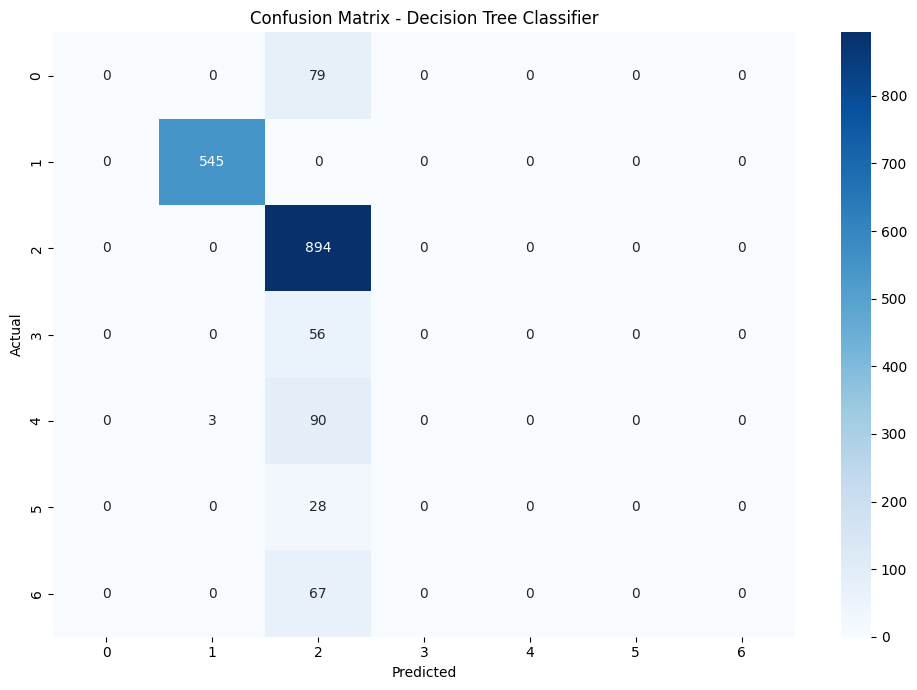

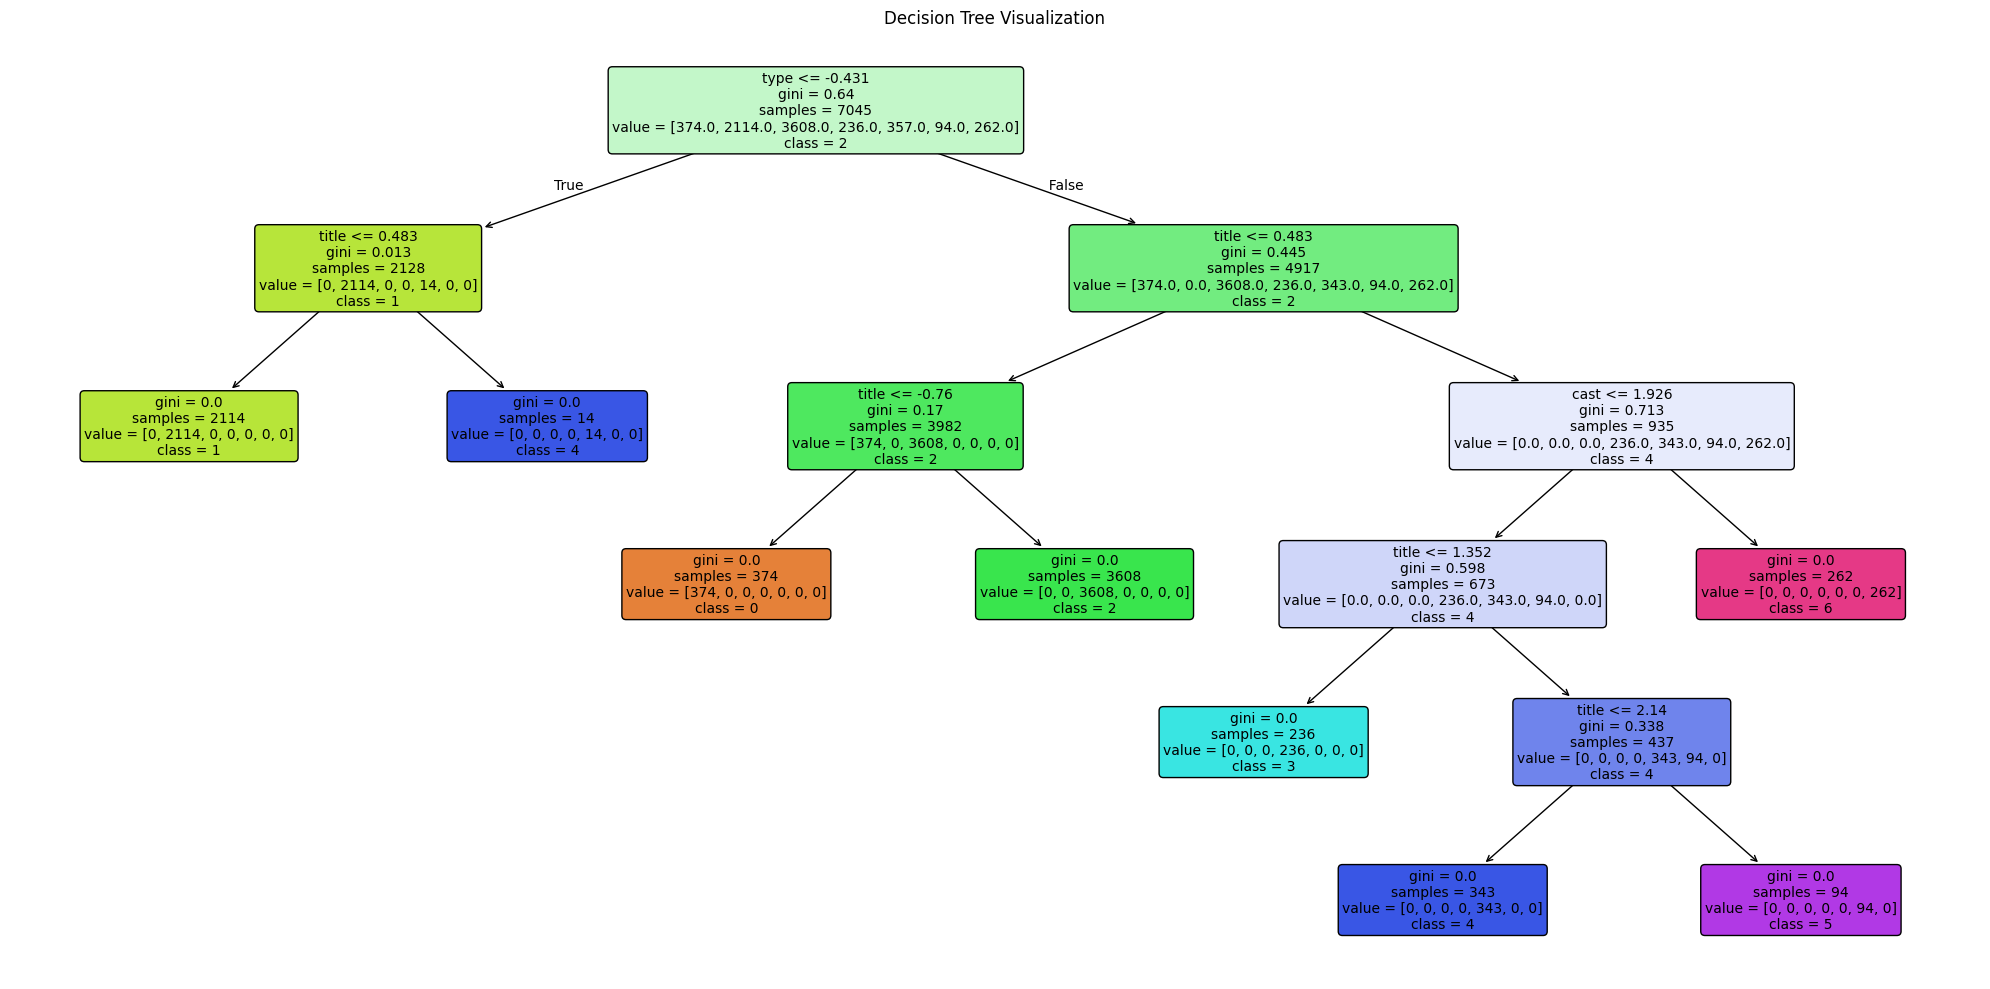

Cross-validation scores:
{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2} mean: 1.000 std: 0.000
{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10} mean: 1.000 std: 0.000
{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 20} mean: 1.000 std: 0.000
{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 2} mean: 1.000 std: 0.000
{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 10} mean: 1.000 std: 0.000
{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 20} mean: 1.000 std: 0.000
{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 10, 'min_samples_split': 2} mean: 0.999 std: 0.001
{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 10, 'min_samples_split': 10} mean: 0.999 std: 0.001
{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 10, 'min_samples_sp

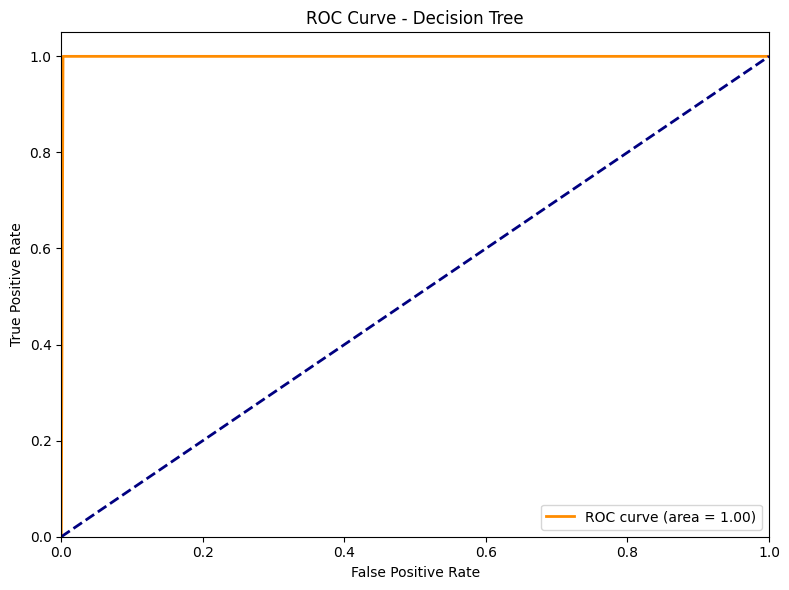

In [ ]:
#decision tree with hyperparameter tuning
!pip install category_encoders
import pandas as pd
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# Downloading the needed resources
nltk.download('punkt')
nltk.download('stopwords')

# Loading the Netflix dataset
data = pd.read_csv('/content/drive/MyDrive/ML/netflix_titles.csv')

# Group genres into broader categories because each genre is classified into more then one genre
def group_genres(genre_str):
    genre_mappings = {
        'TV Shows': ['TV', 'Docuseries', 'Reality TV'],
        'Movies': ['Movies', 'Independent', 'Cult', 'Classic'],
        'Action': ['Action & Adventure'],
        'Drama': ['Dramas'],
        'Comedy': ['Comedies'],
        'Documentary': ['Documentaries']
    }
    if pd.isna(genre_str):
        return 'Other'
    for main_genre, sub_genres in genre_mappings.items():
        if any(sub in genre_str for sub in sub_genres):
            return main_genre
    return 'Other'

# grouping the genres and adding separate column
data['grouped_genre'] = data['genre'].apply(group_genres)

# Mapping the genres to numerical values, so we can easily group them
genre_mapping = {genre: idx for idx, genre in enumerate(data['grouped_genre'].unique())}
data['group_num_genre'] = data['grouped_genre'].map(genre_mapping)

# Defining the features and target, y hat is the genre, using these features
features = ['type', 'title', 'director', 'cast', 'country', 'rating', 'duration', 'description']
X = data[features]
y = data['group_num_genre']

# Check for NaN values and drop them if needed
X = X[y.notna()]
y = y[y.notna()]

# Making sure y is a Pandas Series-this step helps us to hold any data type on y
y = pd.Series(y, name='group_num_genre')

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating a TargetEncoder for categorical features (excluding 'grouped_genre'),
#because we already grouped the grouped_genre
encoder = ce.TargetEncoder(cols=['type', 'title', 'director', 'cast', 'country', 'rating', 'duration'])

# making sure categorical features are extracted properly (excluding 'grouped_genre' as it's already the target)
X_train_cat = X_train[['type', 'title', 'director', 'cast', 'country', 'rating', 'duration']]
X_test_cat = X_test[['type', 'title', 'director', 'cast', 'country', 'rating', 'duration']]

# Reseting for both training and test sets to ensure alignment-because dropping need to be done for the entire row.
X_train_cat.reset_index(drop=True, inplace=True)
X_test_cat.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

# making sure y_train is still a Series
assert isinstance(y_train, pd.Series), "y_train is not a Pandas Series."

# Converting  X_train_cat and X_test_cat to DataFrames explicitly before encoding
X_train_cat = pd.DataFrame(X_train_cat, columns=['type', 'title', 'director', 'cast', 'country', 'rating', 'duration'])
X_test_cat = pd.DataFrame(X_test_cat, columns=['type', 'title', 'director', 'cast', 'country', 'rating', 'duration'])

# Fitting the transformed categorical features
X_train_cat_encoded = encoder.fit_transform(X_train_cat, y_train)
X_test_cat_encoded = encoder.transform(X_test_cat)

# Creating a CountVectorizer for text features
vectorizer = CountVectorizer()

# Fitting and transforming the 'description' column in the training data
X_train_desc_vec = vectorizer.fit_transform(X_train['description'])
X_test_desc_vec = vectorizer.transform(X_test['description'])

# Combining the vectorized text features and encoded categorical features
X_train_combined = pd.concat([pd.DataFrame(X_train_desc_vec.toarray()), X_train_cat_encoded.reset_index(drop=True)], axis=1)
X_test_combined = pd.concat([pd.DataFrame(X_test_desc_vec.toarray()), X_test_cat_encoded.reset_index(drop=True)], axis=1)

# Converting the column names to strings to ensure compatibility
X_train_combined.columns = X_train_combined.columns.astype(str)
X_test_combined.columns = X_test_combined.columns.astype(str)

# Standardize the features
scaler = StandardScaler()
X_train_final = scaler.fit_transform(X_train_combined)
X_test_final = scaler.transform(X_test_combined)

# Initializing the Decision Tree Classifier with hyperparameter tuning
param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10],
    'criterion': ['gini', 'entropy']
}
clf = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=3, n_jobs=-1, verbose=2)


# Train the model using the combined features
clf.fit(X_train_final, y_train)

# Best parameters from GridSearch
print(f"Best parameters: {clf.best_params_}")

# Make predictions on the test set using the combined test features
y_pred = clf.predict(X_test_final)

# Evaluate the model
print("Decision Tree Classifier Results:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(10, 7))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Decision Tree Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# Decision Tree Visualization
plt.figure(figsize=(20, 10))
plot_tree(clf.best_estimator_,
          feature_names=list(X_train_combined.columns),
          class_names=[str(i) for i in genre_mapping.values()],
          filled=True,
          rounded=True,
          fontsize=10)
plt.title('Decision Tree Visualization')
plt.tight_layout()
plt.show()


# Print cross-validation scores
print("Cross-validation scores:")
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
params = clf.cv_results_['params']

for mean, std, param in zip(means, stds, params):
    print(f"{param} mean: {mean:.3f} std: {std:.3f}")

# Making predictions
y_pred = clf.predict(X_test_final)
y_prob = clf.predict_proba(X_test_final)[:, 1]

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob, pos_label=1)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Decision Tree')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Decision Tree Classifier Results:
Accuracy: 0.8166855845629966

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        79
           1       0.99      1.00      1.00       545
           2       0.74      1.00      0.85       894
           3       0.00      0.00      0.00        56
           4       0.00      0.00      0.00        93
           5       0.00      0.00      0.00        28
           6       0.00      0.00      0.00        67

    accuracy                           0.82      1762
   macro avg       0.25      0.29      0.26      1762
weighted avg       0.68      0.82      0.74      1762

Average Precision: 0.24727630202383383
Average Recall: 0.2857142857142857
Average F1 Score: 0.2636360863148199


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

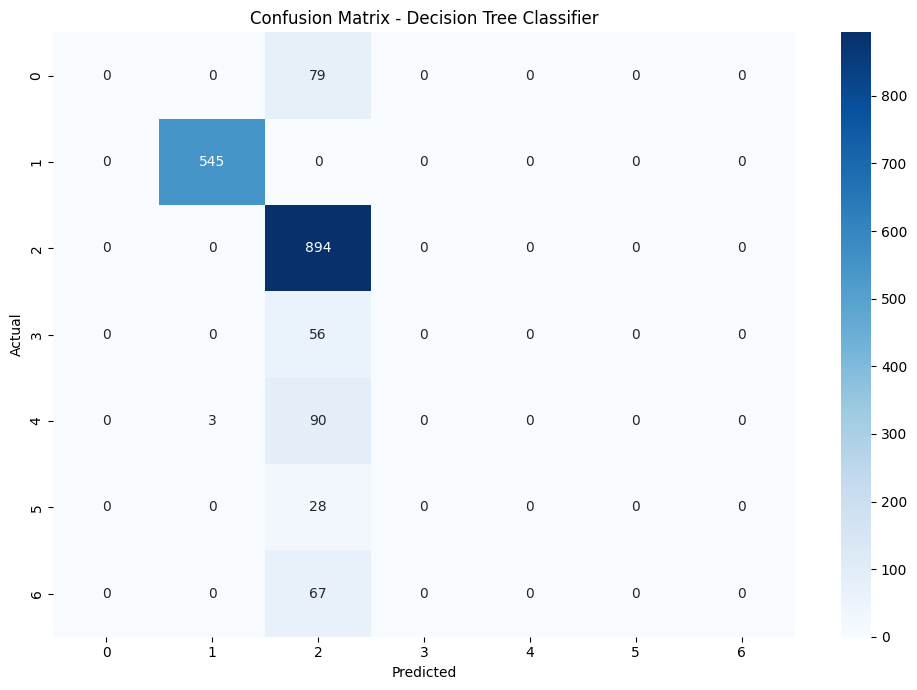

In [ ]:
#decision tree without hyperparameter tuning

!pip install category_encoders
import pandas as pd
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.model_selection import cross_val_score

# Downloading the needed resources
nltk.download('punkt')
nltk.download('stopwords')

# Loading the Netflix dataset
data = pd.read_csv('/content/drive/MyDrive/ML/netflix_titles.csv')

# Group genres into broader categories
def group_genres(genre_str):
    genre_mappings = {
        'TV Shows': ['TV', 'Docuseries', 'Reality TV'],
        'Movies': ['Movies', 'Independent', 'Cult', 'Classic'],
        'Action': ['Action & Adventure'],
        'Drama': ['Dramas'],
        'Comedy': ['Comedies'],
        'Documentary': ['Documentaries']
    }
    if pd.isna(genre_str):
        return 'Other'
    for main_genre, sub_genres in genre_mappings.items():
        if any(sub in genre_str for sub in sub_genres):
            return main_genre
    return 'Other'

# grouping the genres and adding separate column
data['grouped_genre'] = data['genre'].apply(group_genres)

# Mapping the genres to numerical values, so we can easily group them
genre_mapping = {genre: idx for idx, genre in enumerate(data['grouped_genre'].unique())}
data['group_num_genre'] = data['grouped_genre'].map(genre_mapping)

# Defining the features and target, y hat is the genre, using these features
features = ['type', 'title', 'director', 'cast', 'country', 'rating', 'duration', 'description']
X = data[features]
y = data['group_num_genre']

# Checking for NaN values and drop them if needed
X = X[y.notna()]
y = y[y.notna()]

# Making sure y is a Pandas Series-this step helps us to hold any data type on y
y = pd.Series(y, name='group_num_genre')

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating a TargetEncoder for categorical features (excluding 'grouped_genre'),
#because we already grouped the grouped_genre
encoder = ce.TargetEncoder(cols=['type', 'title', 'director', 'cast', 'country', 'rating', 'duration'])

# making sure categorical features are extracted properly (excluding 'grouped_genre' as it's already the target)
X_train_cat = X_train[['type', 'title', 'director', 'cast', 'country', 'rating', 'duration']]
X_test_cat = X_test[['type', 'title', 'director', 'cast', 'country', 'rating', 'duration']]

# Reseting for both training and test sets to ensure alignment-because dropping need to be done for the entire row.
X_train_cat.reset_index(drop=True, inplace=True)
X_test_cat.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

# making sure y_train is still a Series
assert isinstance(y_train, pd.Series), "y_train is not a Pandas Series."

# Converting X_train_cat and X_test_cat to DataFrames explicitly before encoding
X_train_cat = pd.DataFrame(X_train_cat, columns=['type', 'title', 'director', 'cast', 'country', 'rating', 'duration'])
X_test_cat = pd.DataFrame(X_test_cat, columns=['type', 'title', 'director', 'cast', 'country', 'rating', 'duration'])

# Fitting the transformed categorical features
X_train_cat_encoded = encoder.fit_transform(X_train_cat, y_train)
X_test_cat_encoded = encoder.transform(X_test_cat)

# Creating a CountVectorizer for text features
vectorizer = CountVectorizer()

# Fitting and transforming the 'description' column in the training data
X_train_desc_vec = vectorizer.fit_transform(X_train['description'])
X_test_desc_vec = vectorizer.transform(X_test['description'])

# Combining the vectorized text features and encoded categorical features
X_train_combined = pd.concat([pd.DataFrame(X_train_desc_vec.toarray()), X_train_cat_encoded.reset_index(drop=True)], axis=1)
X_test_combined = pd.concat([pd.DataFrame(X_test_desc_vec.toarray()), X_test_cat_encoded.reset_index(drop=True)], axis=1)

# Converting column names to strings
X_train_combined.columns = X_train_combined.columns.astype(str)
X_test_combined.columns = X_test_combined.columns.astype(str)

# Standardizing the features
scaler = StandardScaler()
X_train_final = scaler.fit_transform(X_train_combined)
X_test_final = scaler.transform(X_test_combined)

# Initializig the Decision Tree Classifier
dt_clf = DecisionTreeClassifier(random_state=42)

# Training the model using the combined features
dt_clf.fit(X_train_final, y_train)

# Making the predictions on the test set using the combined test features
y_pred = dt_clf.predict(X_test_final)

# Evaluating the model
print("Decision Tree Classifier Results:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Calculate average precision, recall, and F1 score
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')

print("Average Precision:", precision)
print("Average Recall:", recall)
print("Average F1 Score:", f1)

# Confusion Matrix
plt.figure(figsize=(10, 7))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Decision Tree Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Random Forest Classifier Results:
Accuracy: 0.8195232690124858

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        79
           1       0.99      0.97      0.98       545
           2       0.74      1.00      0.85       894
           3       0.00      0.00      0.00        56
           4       0.92      0.24      0.38        93
           5       0.00      0.00      0.00        28
           6       1.00      0.03      0.06        67

    accuracy                           0.82      1762
   macro avg       0.52      0.32      0.32      1762
weighted avg       0.77      0.82      0.76      1762

Average Precision: 0.521667851357375
Average Recall: 0.31879250010464316
Average F1 Score: 0.3235112202094972


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

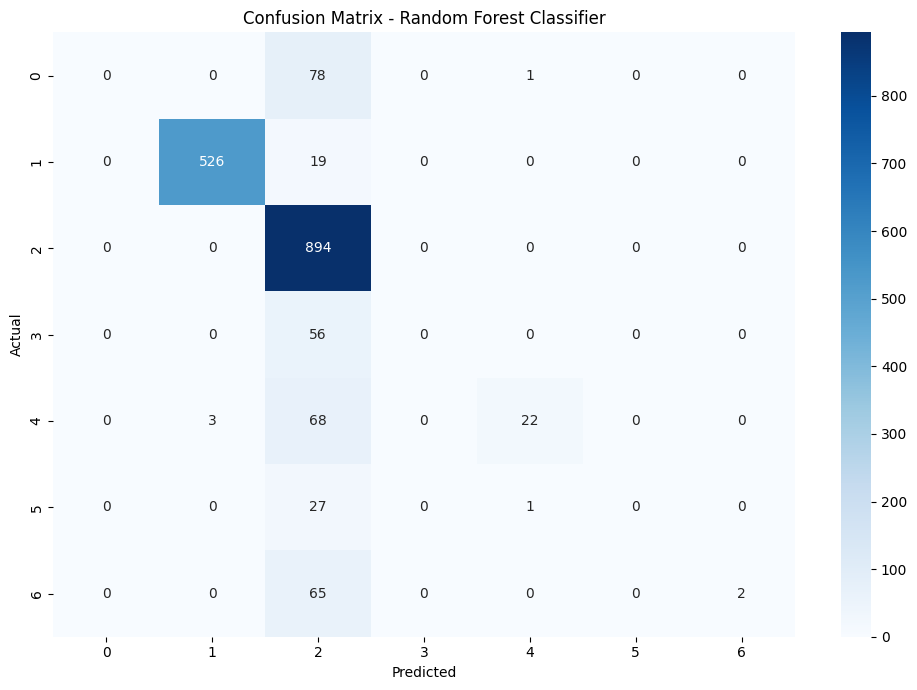

In [ ]:
#random forest without hyperparameter tuning
!pip install category_encoders
import pandas as pd
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.model_selection import cross_val_score

# Downloading the needed resources
nltk.download('punkt')
nltk.download('stopwords')

# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/ML/netflix_titles.csv')

# Group genres into broader categories
def group_genres(genre_str):
    genre_mappings = {
        'TV Shows': ['TV', 'Docuseries', 'Reality TV'],
        'Movies': ['Movies', 'Independent', 'Cult', 'Classic'],
        'Action': ['Action & Adventure'],
        'Drama': ['Dramas'],
        'Comedy': ['Comedies'],
        'Documentary': ['Documentaries']
    }
    if pd.isna(genre_str):
        return 'Other'
    for main_genre, sub_genres in genre_mappings.items():
        if any(sub in genre_str for sub in sub_genres):
            return main_genre
    return 'Other'

# Apply genre grouping and add a column
data['grouped_genre'] = data['genre'].apply(group_genres)

# Map genres to numerical values
genre_mapping = {genre: idx for idx, genre in enumerate(data['grouped_genre'].unique())}
data['group_num_genre'] = data['grouped_genre'].map(genre_mapping)

# Define features and target
features = ['type', 'title', 'director', 'cast', 'country', 'rating', 'duration', 'description']
X = data[features]
y = data['group_num_genre']

# Check for NaN values and drop them if needed
X = X[y.notna()]
y = y[y.notna()]

# Ensure y is a Pandas Series
y = pd.Series(y, name='group_num_genre')

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a TargetEncoder for categorical features (excluding 'grouped_genre')
encoder = ce.TargetEncoder(cols=['type', 'title', 'director', 'cast', 'country', 'rating', 'duration'])

# Ensure categorical features are extracted properly (excluding 'grouped_genre' as it's already the target)
X_train_cat = X_train[['type', 'title', 'director', 'cast', 'country', 'rating', 'duration']]
X_test_cat = X_test[['type', 'title', 'director', 'cast', 'country', 'rating', 'duration']]

# Reset indices for both training and test sets to ensure alignment
X_train_cat.reset_index(drop=True, inplace=True)
X_test_cat.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

# Ensure y_train is still a Series
assert isinstance(y_train, pd.Series), "y_train is not a Pandas Series."

# Convert X_train_cat and X_test_cat to DataFrames explicitly before encoding
X_train_cat = pd.DataFrame(X_train_cat, columns=['type', 'title', 'director', 'cast', 'country', 'rating', 'duration'])
X_test_cat = pd.DataFrame(X_test_cat, columns=['type', 'title', 'director', 'cast', 'country', 'rating', 'duration'])

# Fit and transform the categorical features
X_train_cat_encoded = encoder.fit_transform(X_train_cat, y_train)
X_test_cat_encoded = encoder.transform(X_test_cat)

# Create a CountVectorizer for text features
vectorizer = CountVectorizer()

# Fit and transform the 'description' column in the training data
X_train_desc_vec = vectorizer.fit_transform(X_train['description'])
X_test_desc_vec = vectorizer.transform(X_test['description'])

# Combine the vectorized text features and encoded categorical features
X_train_combined = pd.concat([pd.DataFrame(X_train_desc_vec.toarray()), X_train_cat_encoded.reset_index(drop=True)], axis=1)
X_test_combined = pd.concat([pd.DataFrame(X_test_desc_vec.toarray()), X_test_cat_encoded.reset_index(drop=True)], axis=1)

# Convert column names to strings
X_train_combined.columns = X_train_combined.columns.astype(str)
X_test_combined.columns = X_test_combined.columns.astype(str)

# Standardize the features
scaler = StandardScaler()
X_train_final = scaler.fit_transform(X_train_combined)
X_test_final = scaler.transform(X_test_combined)

# Initialize the Random Forest Classifier
rf_clf = RandomForestClassifier(random_state=42)

# Train the model using the combined features
rf_clf.fit(X_train_final, y_train)

# Make predictions on the test set using the combined test features
y_pred = rf_clf.predict(X_test_final)

# Evaluate the model
print("Random Forest Classifier Results:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Calculate average precision, recall, and F1 score
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')

print("Average Precision:", precision)
print("Average Recall:", recall)
print("Average F1 Score:", f1)

# Confusion Matrix
plt.figure(figsize=(10, 7))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Random Forest Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()


In [ ]:
# Random Forest with hyperparameter tuning

!pip install category_encoders
import pandas as pd
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce

# Downloading the needed resources
nltk.download('punkt')
nltk.download('stopwords')

# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/ML/netflix_titles.csv')

# Group genres into broader categories
def group_genres(genre_str):
    genre_mappings = {
        'TV Shows': ['TV', 'Docuseries', 'Reality TV'],
        'Movies': ['Movies', 'Independent', 'Cult', 'Classic'],
        'Action': ['Action & Adventure'],
        'Drama': ['Dramas'],
        'Comedy': ['Comedies'],
        'Documentary': ['Documentaries']
    }
    if pd.isna(genre_str):
        return 'Other'
    for main_genre, sub_genres in genre_mappings.items():
        if any(sub in genre_str for sub in sub_genres):
            return main_genre
    return 'Other'

# Apply genre grouping and add a column
data['grouped_genre'] = data['genre'].apply(group_genres)

# Map genres to numerical values
genre_mapping = {genre: idx for idx, genre in enumerate(data['grouped_genre'].unique())}
data['group_num_genre'] = data['grouped_genre'].map(genre_mapping)

# Define features and target
features = ['type', 'title', 'director', 'cast', 'country', 'rating', 'duration', 'description']
X = data[features]
y = data['group_num_genre']

# Check for NaN values and drop them if needed
X = X[y.notna()]
y = y[y.notna()]

# Ensure y is a Pandas Series
y = pd.Series(y, name='group_num_genre')

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a TargetEncoder for categorical features (excluding 'grouped_genre')
encoder = ce.TargetEncoder(cols=['type', 'title', 'director', 'cast', 'country', 'rating', 'duration'])

# Ensure categorical features are extracted properly (excluding 'grouped_genre' as it's already the target)
X_train_cat = X_train[['type', 'title', 'director', 'cast', 'country', 'rating', 'duration']]
X_test_cat = X_test[['type', 'title', 'director', 'cast', 'country', 'rating', 'duration']]

# Reset indices for both training and test sets to ensure alignment
X_train_cat.reset_index(drop=True, inplace=True)
X_test_cat.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

# Ensure y_train is still a Series
assert isinstance(y_train, pd.Series), "y_train is not a Pandas Series."

# Convert X_train_cat and X_test_cat to DataFrames explicitly before encoding
X_train_cat = pd.DataFrame(X_train_cat, columns=['type', 'title', 'director', 'cast', 'country', 'rating', 'duration'])
X_test_cat = pd.DataFrame(X_test_cat, columns=['type', 'title', 'director', 'cast', 'country', 'rating', 'duration'])

# Fit and transform the categorical features
X_train_cat_encoded = encoder.fit_transform(X_train_cat, y_train)
X_test_cat_encoded = encoder.transform(X_test_cat)

# Create a CountVectorizer for text features
vectorizer = CountVectorizer()

# Fit and transform the 'description' column in the training data
X_train_desc_vec = vectorizer.fit_transform(X_train['description'])
X_test_desc_vec = vectorizer.transform(X_test['description'])

# Combine the vectorized text features and encoded categorical features
X_train_combined = pd.concat([pd.DataFrame(X_train_desc_vec.toarray()), X_train_cat_encoded.reset_index(drop=True)], axis=1)
X_test_combined = pd.concat([pd.DataFrame(X_test_desc_vec.toarray()), X_test_cat_encoded.reset_index(drop=True)], axis=1)

# Convert column names to strings
X_train_combined.columns = X_train_combined.columns.astype(str)
X_test_combined.columns = X_test_combined.columns.astype(str)

# Standardize the features
scaler = StandardScaler()
X_train_final = scaler.fit_transform(X_train_combined)
X_test_final = scaler.transform(X_test_combined)

# Define hyperparameters to test
param_grid_rf = [
    {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 2},
    {'n_estimators': 200, 'max_depth': 20, 'min_samples_split': 5},
    {'n_estimators': 300, 'max_depth': 30, 'min_samples_split': 10}
]

# Loop through hyperparameters and train model
best_accuracy = 0
best_params = None
best_model = None
for params in param_grid_rf:
    rf_clf = RandomForestClassifier(**params, random_state=42)
    rf_clf.fit(X_train_final, y_train)
    y_pred = rf_clf.predict(X_test_final)
    accuracy = accuracy_score(y_test, y_pred)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = params
        best_model = rf_clf

# Print best parameters and accuracy
print(f"Best parameters for Random Forest: {best_params}")
print(f"Best accuracy: {best_accuracy}")

# Make predictions on the test set using the best model
y_pred = best_model.predict(X_test_final)

# Evaluate the model
print("Random Forest Classifier Results:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Calculate average precision, recall, and F1 score
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')

print("Average Precision:", precision)
print("Average Recall:", recall)
print("Average F1 Score:", f1)

# Confusion Matrix
plt.figure(figsize=(10, 7))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Random Forest Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Random Forest Classifier Results:
Accuracy: 0.8195232690124858

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        79
           1       0.99      0.97      0.98       545
           2       0.74      1.00      0.85       894
           3       0.00      0.00      0.00        56
           4       0.92      0.24      0.38        93
           5       0.00      0.00      0.00        28
           6       1.00      0.03      0.06        67

    accuracy                           0.82      1762
   macro avg       0.52      0.32      0.32      1762
weighted avg       0.77      0.82      0.76      1762

Average Precision: 0.521667851357375
Average Recall: 0.31879250010464316
Average F1 Score: 0.3235112202094972


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

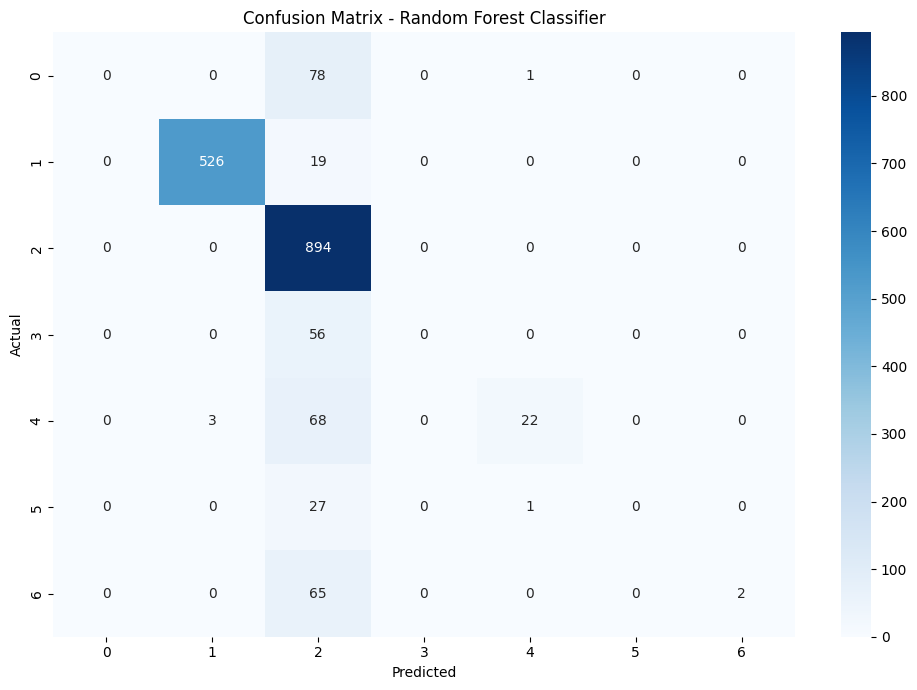

In [ ]:
#Random Forest without hyperparameter turning
!pip install category_encoders
import pandas as pd
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce

# Downloading the needed resources
nltk.download('punkt')
nltk.download('stopwords')

# Loading the Netflix dataset
data = pd.read_csv('/content/drive/MyDrive/ML/netflix_titles.csv')

# Group genres into broader categories because each genre is classified into more then one genre
#now the genres are classified as the first genre
def group_genres(genre_str):
    genre_mappings = {
        'TV Shows': ['TV', 'Docuseries', 'Reality TV'],
        'Movies': ['Movies', 'Independent', 'Cult', 'Classic'],
        'Action': ['Action & Adventure'],
        'Drama': ['Dramas'],
        'Comedy': ['Comedies'],
        'Documentary': ['Documentaries']
    }
    if pd.isna(genre_str):
        return 'Other'
    for main_genre, sub_genres in genre_mappings.items():
        if any(sub in genre_str for sub in sub_genres):
            return main_genre
    return 'Other'


# grouping the genres and adding separate column
data['grouped_genre'] = data['genre'].apply(group_genres)

# Mapping the genres to numerical values, so we can easily group them
genre_mapping = {genre: idx for idx, genre in enumerate(data['grouped_genre'].unique())}
data['group_num_genre'] = data['grouped_genre'].map(genre_mapping)

# Defining the features and target, y hat is the genre, using these features
features = ['type', 'title', 'director', 'cast', 'country', 'rating', 'duration', 'description']
X = data[features]
y = data['group_num_genre']

# Checking for NaN values and drop them if needed
X = X[y.notna()]
y = y[y.notna()]

# Making sure y is a Pandas Series-this step helps us to hold any data type on y
y = pd.Series(y, name='group_num_genre')

# Spliting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating a TargetEncoder for categorical features (excluding 'grouped_genre')
encoder = ce.TargetEncoder(cols=['type', 'title', 'director', 'cast', 'country', 'rating', 'duration'])

# making sure categorical features are extracted properly (excluding 'grouped_genre' as it's already the target)
X_train_cat = X_train[['type', 'title', 'director', 'cast', 'country', 'rating', 'duration']]
X_test_cat = X_test[['type', 'title', 'director', 'cast', 'country', 'rating', 'duration']]

# Reseting for both training and test sets to ensure alignment-because dropping need to be done for the entire row.
X_train_cat.reset_index(drop=True, inplace=True)
X_test_cat.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

# making sure y_train is still a Series
assert isinstance(y_train, pd.Series), "y_train is not a Pandas Series."

# Converting  X_train_cat and X_test_cat to DataFrames explicitly before encoding
X_train_cat = pd.DataFrame(X_train_cat, columns=['type', 'title', 'director', 'cast', 'country', 'rating', 'duration'])
X_test_cat = pd.DataFrame(X_test_cat, columns=['type', 'title', 'director', 'cast', 'country', 'rating', 'duration'])

# Fitting the transformed categorical features
X_train_cat_encoded = encoder.fit_transform(X_train_cat, y_train)
X_test_cat_encoded = encoder.transform(X_test_cat)

# Creating a CountVectorizer for text features
vectorizer = CountVectorizer()

# Fitting and transforming the 'description' column in the training data
X_train_desc_vec = vectorizer.fit_transform(X_train['description'])
X_test_desc_vec = vectorizer.transform(X_test['description'])

# Combining the vectorized text features and encoded categorical features
X_train_combined = pd.concat([pd.DataFrame(X_train_desc_vec.toarray()), X_train_cat_encoded.reset_index(drop=True)], axis=1)
X_test_combined = pd.concat([pd.DataFrame(X_test_desc_vec.toarray()), X_test_cat_encoded.reset_index(drop=True)], axis=1)

# Converting column names to strings
X_train_combined.columns = X_train_combined.columns.astype(str)
X_test_combined.columns = X_test_combined.columns.astype(str)

# Standardizing the features
scaler = StandardScaler()
X_train_final = scaler.fit_transform(X_train_combined)
X_test_final = scaler.transform(X_test_combined)

# Initializing the Random Forest Classifier
rf_clf = RandomForestClassifier(random_state=42)

# Training the model using the combined features
rf_clf.fit(X_train_final, y_train)

# Making predictions on the test set using the combined test features
y_pred = rf_clf.predict(X_test_final)

# Evaluating the model
print("Random Forest Classifier Results:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Calculating average precision, recall, and F1 score
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')

print("Average Precision:", precision)
print("Average Recall:", recall)
print("Average F1 Score:", f1)

# Confusion Matrix
plt.figure(figsize=(10, 7))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Random Forest Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Naive Bayes Classifier Results:
Accuracy: 0.4931895573212259

Classification Report:
              precision    recall  f1-score   support

           0       0.24      0.33      0.28        79
           1       0.49      0.38      0.43       545
           2       0.63      0.63      0.63       894
           3       0.03      0.04      0.03        56
           4       0.49      0.47      0.48        93
           5       0.05      0.11      0.07        28
           6       0.24      0.36      0.28        67

    accuracy                           0.49      1762
   macro avg       0.31      0.33      0.31      1762
weighted avg       0.52      0.49      0.50      1762

Average Precision: 0.3077250454653527
Average Recall: 0.3303074908998817
Average F1 Score: 0.31331008601743365


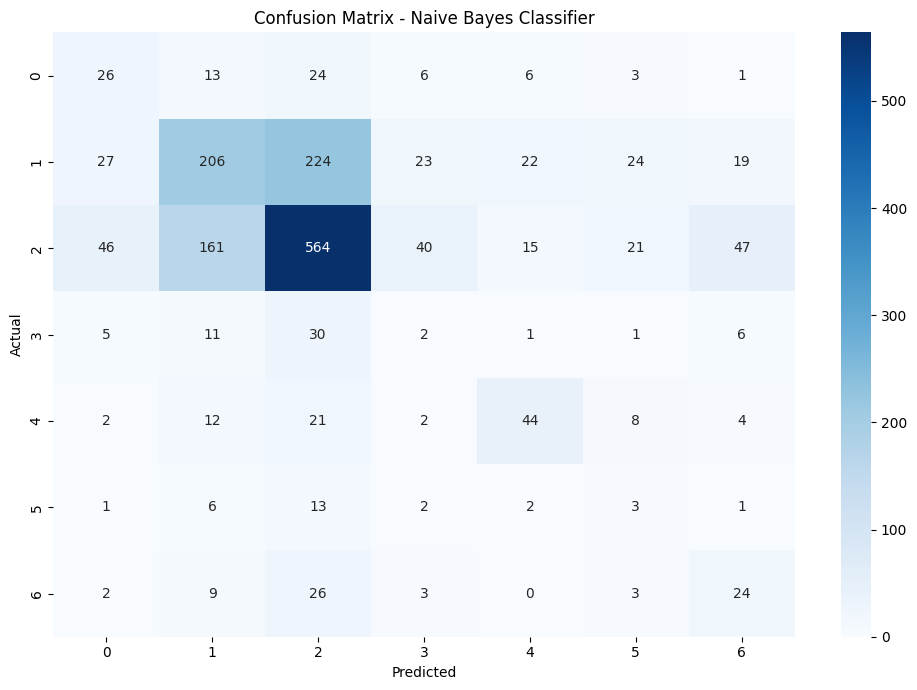

In [ ]:
#Naive Bayes without hyperparameter tuning
!pip install category_encoders
import pandas as pd
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce

# Downloading the needed resources
nltk.download('punkt')
nltk.download('stopwords')

# Loading the Netflix dataset
data = pd.read_csv('/content/drive/MyDrive/ML/netflix_titles.csv')

# Group genres into broader categories because each genre is classified into more then one genre
#now the genres are classified as the first genre
def group_genres(genre_str):
    genre_mappings = {
        'TV Shows': ['TV', 'Docuseries', 'Reality TV'],
        'Movies': ['Movies', 'Independent', 'Cult', 'Classic'],
        'Action': ['Action & Adventure'],
        'Drama': ['Dramas'],
        'Comedy': ['Comedies'],
        'Documentary': ['Documentaries']
    }
    if pd.isna(genre_str):
        return 'Other'
    for main_genre, sub_genres in genre_mappings.items():
        if any(sub in genre_str for sub in sub_genres):
            return main_genre
    return 'Other'

# grouping the genres and adding separate column
data['grouped_genre'] = data['genre'].apply(group_genres)

# Mapping the genres to numerical values, so we can easily group them
genre_mapping = {genre: idx for idx, genre in enumerate(data['grouped_genre'].unique())}
data['group_num_genre'] = data['grouped_genre'].map(genre_mapping)

# Defining the features and target, y hat is the genre, using these features
features = ['type', 'title', 'director', 'cast', 'country', 'rating', 'duration', 'description']
X = data[features]
y = data['group_num_genre']

# Checking for NaN values and drop them if needed
X = X[y.notna()]
y = y[y.notna()]

# Making sure y is a Pandas Series-this step helps us to hold any data type on y
y = pd.Series(y, name='group_num_genre')

# Spliting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating a TargetEncoder for categorical features (excluding 'grouped_genre')
encoder = ce.TargetEncoder(cols=['type', 'title', 'director', 'cast', 'country', 'rating', 'duration'])

# making sure categorical features are extracted properly (excluding 'grouped_genre' as it's already the target)
X_train_cat = X_train[['type', 'title', 'director', 'cast', 'country', 'rating', 'duration']]
X_test_cat = X_test[['type', 'title', 'director', 'cast', 'country', 'rating', 'duration']]

# Reseting for both training and test sets to ensure alignment-because dropping need to be done for the entire row.
X_train_cat.reset_index(drop=True, inplace=True)
X_test_cat.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

## making sure y_train is still a Series
assert isinstance(y_train, pd.Series), "y_train is not a Pandas Series."

# Converting  X_train_cat and X_test_cat to DataFrames explicitly before encoding
X_train_cat = pd.DataFrame(X_train_cat, columns=['type', 'title', 'director', 'cast', 'country', 'rating', 'duration'])
X_test_cat = pd.DataFrame(X_test_cat, columns=['type', 'title', 'director', 'cast', 'country', 'rating', 'duration'])

# Fitting the transformed categorical features
X_train_cat_encoded = encoder.fit_transform(X_train_cat, y_train)
X_test_cat_encoded = encoder.transform(X_test_cat)

# Creating a CountVectorizer for text features
vectorizer = CountVectorizer()

# Fitting and transforming the 'description' column in the training data
X_train_desc_vec = vectorizer.fit_transform(X_train['description'])
X_test_desc_vec = vectorizer.transform(X_test['description'])

# Combining the vectorized text features and encoded categorical features
X_train_combined = pd.concat([pd.DataFrame(X_train_desc_vec.toarray()), X_train_cat_encoded.reset_index(drop=True)], axis=1)
X_test_combined = pd.concat([pd.DataFrame(X_test_desc_vec.toarray()), X_test_cat_encoded.reset_index(drop=True)], axis=1)

# Converting the column names to strings
X_train_combined.columns = X_train_combined.columns.astype(str)
X_test_combined.columns = X_test_combined.columns.astype(str)

# Standardizing the features
scaler = StandardScaler(with_mean=False)  # Naive Bayes requires positive values
X_train_final = scaler.fit_transform(X_train_combined)
X_test_final = scaler.transform(X_test_combined)

# Initializing the Naive Bayes Classifier
nb_clf = MultinomialNB()

# Training the model using the combined features
nb_clf.fit(X_train_final, y_train)

# Making predictions on the test set using the combined test features
y_pred = nb_clf.predict(X_test_final)

# Evaluating the model
print("Naive Bayes Classifier Results:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Calculating average precision, recall, and F1 score
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')

print("Average Precision:", precision)
print("Average Recall:", recall)
print("Average F1 Score:", f1)

# Confusion Matrix
plt.figure(figsize=(10, 7))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Naive Bayes Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best parameters: {'alpha': 0.01}
Naive Bayes Classifier Results:
Accuracy: 0.5306469920544835

Classification Report:
              precision    recall  f1-score   support

           0       0.25      0.23      0.24        79
           1       0.47      0.41      0.44       545
           2       0.60      0.72      0.66       894
           3       0.00      0.00      0.00        56
           4       0.55      0.37      0.44        93
           5       0.08      0.04      0.05        28
           6       0.24      0.13      0.17        67

    accuracy                           0.53      1762
   macro avg       0.31      0.27      0.29      1762
weighted avg       0.50      0.53      0.51      1762

Average Precision: 0.3131373973349368
Average Recall: 0.27169638409336194
Average F1 Score: 0.28532626721784277


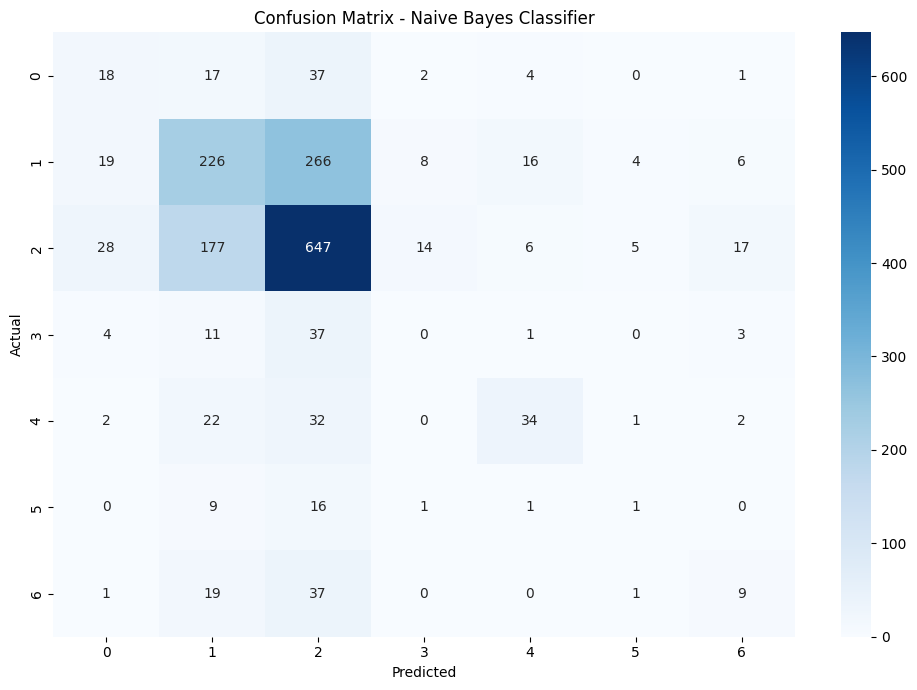

In [ ]:
#Naive Bayes with hyperparameter tuning
!pip install category_encoders
import pandas as pd
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce

# Downloading the needed resources
nltk.download('punkt')
nltk.download('stopwords')

# Loading the Netflix dataset
data = pd.read_csv('/content/drive/MyDrive/ML/netflix_titles.csv')

## Group genres into broader categories because each genre is classified into more then one genre
#now the genres are classified as the first genre
def group_genres(genre_str):
    genre_mappings = {
        'TV Shows': ['TV', 'Docuseries', 'Reality TV'],
        'Movies': ['Movies', 'Independent', 'Cult', 'Classic'],
        'Action': ['Action & Adventure'],
        'Drama': ['Dramas'],
        'Comedy': ['Comedies'],
        'Documentary': ['Documentaries']
    }
    if pd.isna(genre_str):
        return 'Other'
    for main_genre, sub_genres in genre_mappings.items():
        if any(sub in genre_str for sub in sub_genres):
            return main_genre
    return 'Other'

# grouping the genres and adding separate column
data['grouped_genre'] = data['genre'].apply(group_genres)

# Mapping the genres to numerical values, so we can easily group them
genre_mapping = {genre: idx for idx, genre in enumerate(data['grouped_genre'].unique())}
data['group_num_genre'] = data['grouped_genre'].map(genre_mapping)

# Defining the features and target, y hat is the genre, using these features
features = ['type', 'title', 'director', 'cast', 'country', 'rating', 'duration', 'description']
X = data[features]
y = data['group_num_genre']

# Checking for NaN values and drop them if needed
X = X[y.notna()]
y = y[y.notna()]

# Making sure y is a Pandas Series-this step helps us to hold any data type on y
y = pd.Series(y, name='group_num_genre')

# Spliting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating a TargetEncoder for categorical features (excluding 'grouped_genre')
encoder = ce.TargetEncoder(cols=['type', 'title', 'director', 'cast', 'country', 'rating', 'duration'])

#Making sure categorical features are extracted properly (excluding 'grouped_genre' as it's already the target)
X_train_cat = X_train[['type', 'title', 'director', 'cast', 'country', 'rating', 'duration']]
X_test_cat = X_test[['type', 'title', 'director', 'cast', 'country', 'rating', 'duration']]

# Reseting the indices for both training and test sets to ensure alignment
X_train_cat.reset_index(drop=True, inplace=True)
X_test_cat.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

#making sure the y_train is still a Series
assert isinstance(y_train, pd.Series), "y_train is not a Pandas Series."

# Converting X_train_cat and X_test_cat to DataFrames explicitly before encoding
X_train_cat = pd.DataFrame(X_train_cat, columns=['type', 'title', 'director', 'cast', 'country', 'rating', 'duration'])
X_test_cat = pd.DataFrame(X_test_cat, columns=['type', 'title', 'director', 'cast', 'country', 'rating', 'duration'])

# Fitting and transform the categorical features
X_train_cat_encoded = encoder.fit_transform(X_train_cat, y_train)
X_test_cat_encoded = encoder.transform(X_test_cat)

# Creating a CountVectorizer for text features
vectorizer = CountVectorizer()

# Fitting and transforming the 'description' column in the training data
X_train_desc_vec = vectorizer.fit_transform(X_train['description'])
X_test_desc_vec = vectorizer.transform(X_test['description'])

# Combining the vectorized text features and encoded categorical features
X_train_combined = pd.concat([pd.DataFrame(X_train_desc_vec.toarray()), X_train_cat_encoded.reset_index(drop=True)], axis=1)
X_test_combined = pd.concat([pd.DataFrame(X_test_desc_vec.toarray()), X_test_cat_encoded.reset_index(drop=True)], axis=1)

# Converting column names to strings
X_train_combined.columns = X_train_combined.columns.astype(str)
X_test_combined.columns = X_test_combined.columns.astype(str)

# Standardizing the features
scaler = StandardScaler(with_mean=False)  # Naive Bayes requires positive values
X_train_final = scaler.fit_transform(X_train_combined)
X_test_final = scaler.transform(X_test_combined)

# Initializing the Naive Bayes Classifier with hyperparameter tuning
param_grid = {
    'alpha': [0.01, 0.1, 1, 10],  # Smoothing parameter for Naive Bayes
}
nb_clf = GridSearchCV(MultinomialNB(), param_grid, cv=3, n_jobs=-1, verbose=2)

# Training the model using the combined features
nb_clf.fit(X_train_final, y_train)

# Best parameters from GridSearch
print(f"Best parameters: {nb_clf.best_params_}")

# Making the predictions on the test set using the combined test features
y_pred = nb_clf.predict(X_test_final)

# Evaluating the model
print("Naive Bayes Classifier Results:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Calculating the average precision, recall, and F1 score
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')

print("Average Precision:", precision)
print("Average Recall:", recall)
print("Average F1 Score:", f1)

# Confusion Matrix
plt.figure(figsize=(10, 7))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Naive Bayes Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Gradient Boosting Classifier Results:
Accuracy: 0.5073779795686719

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        79
           1       0.00      0.00      0.00       545
           2       0.51      1.00      0.67       894
           3       0.00      0.00      0.00        56
           4       0.00      0.00      0.00        93
           5       0.00      0.00      0.00        28
           6       0.00      0.00      0.00        67

    accuracy                           0.51      1762
   macro avg       0.07      0.14      0.10      1762
weighted avg       0.26      0.51      0.34      1762

Average Precision: 0.07248256850981027
Average Recall: 0.14285714285714285
Average F1 Score: 0.09617039586919106


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

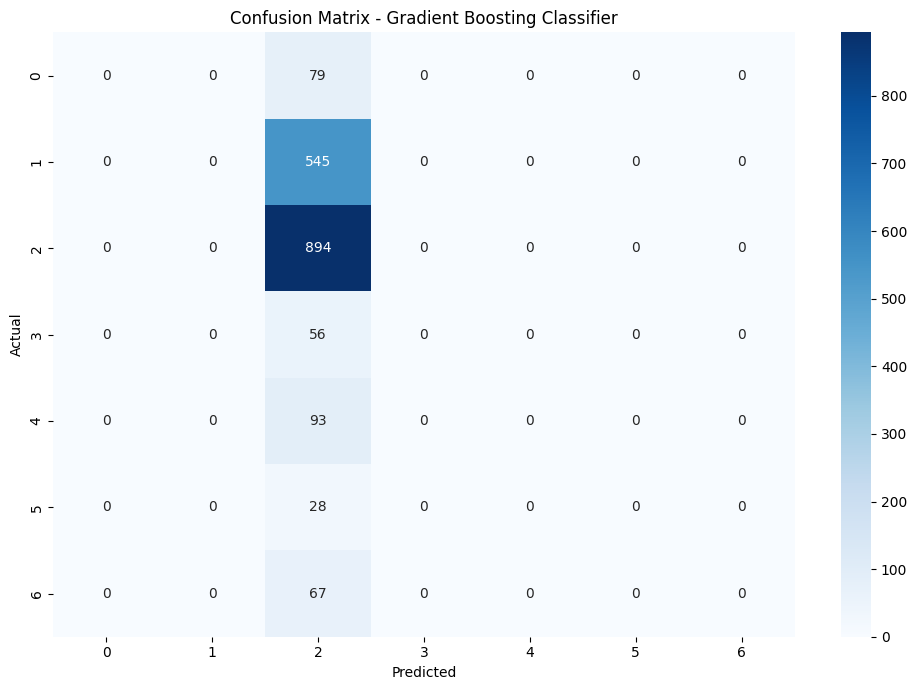

In [ ]:
#gradient boosting without hyperparameter tuning
!pip install category_encoders
import pandas as pd
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce

# Downloading the needed resources
nltk.download('punkt')
nltk.download('stopwords')

# Loading the Netflix dataset
data = pd.read_csv('/content/drive/MyDrive/ML/netflix_titles.csv')

# Group genres into broader categories because each genre is classified into more then one genre
#now the genres are classified as the first genre
def group_genres(genre_str):
    genre_mappings = {
        'TV Shows': ['TV', 'Docuseries', 'Reality TV'],
        'Movies': ['Movies', 'Independent', 'Cult', 'Classic'],
        'Action': ['Action & Adventure'],
        'Drama': ['Dramas'],
        'Comedy': ['Comedies'],
        'Documentary': ['Documentaries']
    }
    if pd.isna(genre_str):
        return 'Other'
    for main_genre, sub_genres in genre_mappings.items():
        if any(sub in genre_str for sub in sub_genres):
            return main_genre
    return 'Other'

# grouping the genres and adding separate column
data['grouped_genre'] = data['genre'].apply(group_genres)

# Mapping the genres to numerical values, so we can easily group them
genre_mapping = {genre: idx for idx, genre in enumerate(data['grouped_genre'].unique())}
data['group_num_genre'] = data['grouped_genre'].map(genre_mapping)

# Defining the features and target, y hat is the genre, using these features
features = ['type', 'title', 'director', 'cast', 'country', 'rating', 'duration', 'description']
X = data[features]
y = data['group_num_genre']

# Checking for NaN values and drop them if needed
X = X[y.notna()]
y = y[y.notna()]

# Making sure y is a Pandas Series-this step helps us to hold any data type on y
y = pd.Series(y, name='group_num_genre')

# Spliting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating a TargetEncoder for categorical features (excluding 'grouped_genre')
encoder = ce.TargetEncoder(cols=['type', 'title', 'director', 'cast', 'country', 'rating', 'duration'])

# Making sure categorical features are extracted properly (excluding 'grouped_genre' as it's already the target)
X_train_cat = X_train[['type', 'title', 'director', 'cast', 'country', 'rating', 'duration']]
X_test_cat = X_test[['type', 'title', 'director', 'cast', 'country', 'rating', 'duration']]

# Reseting indices for both training and test sets to ensure alignment
X_train_cat.reset_index(drop=True, inplace=True)
X_test_cat.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

#making sure y_train is still a Series
assert isinstance(y_train, pd.Series), "y_train is not a Pandas Series."

# Converting X_train_cat and X_test_cat to DataFrames explicitly before encoding
X_train_cat = pd.DataFrame(X_train_cat, columns=['type', 'title', 'director', 'cast', 'country', 'rating', 'duration'])
X_test_cat = pd.DataFrame(X_test_cat, columns=['type', 'title', 'director', 'cast', 'country', 'rating', 'duration'])

# Fitting and transforming the categorical features
X_train_cat_encoded = encoder.fit_transform(X_train_cat, y_train)
X_test_cat_encoded = encoder.transform(X_test_cat)

# Create a CountVectorizer for text features
vectorizer = CountVectorizer()

# Fitting  and transforming the 'description' column in the training data
X_train_desc_vec = vectorizer.fit_transform(X_train['description'])
X_test_desc_vec = vectorizer.transform(X_test['description'])

# Combining the vectorized text features and encoded categorical features
X_train_combined = pd.concat([pd.DataFrame(X_train_desc_vec.toarray()), X_train_cat_encoded.reset_index(drop=True)], axis=1)
X_test_combined = pd.concat([pd.DataFrame(X_test_desc_vec.toarray()), X_test_cat_encoded.reset_index(drop=True)], axis=1)

# Converting column names to strings
X_train_combined.columns = X_train_combined.columns.astype(str)
X_test_combined.columns = X_test_combined.columns.astype(str)

# Standardize the features
scaler = StandardScaler()
X_train_final = scaler.fit_transform(X_train_combined)
X_test_final = scaler.transform(X_test_combined)

# Initializing the Gradient Boosting Classifier with optimized parameters for runtime
gb_clf = GradientBoostingClassifier(
    n_estimators=100,  # Reduced number of trees
    learning_rate=0.1,  # Standard learning rate
    max_depth=3,  # Shallow trees
    subsample=0.8,  # Use 80% of the data for each tree
    random_state=42
)

# Training the model using the combined features
gb_clf.fit(X_train_final, y_train)

# Making predictions on the test set using the combined test features
y_pred = gb_clf.predict(X_test_final)

# Evaluating the model
print("Gradient Boosting Classifier Results:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Calculating average precision, recall, and F1 score
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')

print("Average Precision:", precision)
print("Average Recall:", recall)
print("Average F1 Score:", f1)

# Confusion Matrix
plt.figure(figsize=(10, 7))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Gradient Boosting Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

In [ ]:
#Gradient boosting with hyperparatuning

!pip install category_encoders
import pandas as pd
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce
from sklearn.ensemble import GradientBoostingClassifier

# Downloading the needed resources
nltk.download('punkt')
nltk.download('stopwords')

# Loading the Netflix dataset
data = pd.read_csv('/content/drive/MyDrive/ML/netflix_titles.csv')

# Group genres into broader categories because each genre is classified into more then one genre
#now the genres are classified as the first genre
def group_genres(genre_str):
    genre_mappings = {
        'TV Shows': ['TV', 'Docuseries', 'Reality TV'],
        'Movies': ['Movies', 'Independent', 'Cult', 'Classic'],
        'Action': ['Action & Adventure'],
        'Drama': ['Dramas'],
        'Comedy': ['Comedies'],
        'Documentary': ['Documentaries']
    }
    if pd.isna(genre_str):
        return 'Other'
    for main_genre, sub_genres in genre_mappings.items():
        if any(sub in genre_str for sub in sub_genres):
            return main_genre
    return 'Other'

# grouping the genres and adding separate column
data['grouped_genre'] = data['genre'].apply(group_genres)

# Mapping the genres to numerical values, so we can easily group them
genre_mapping = {genre: idx for idx, genre in enumerate(data['grouped_genre'].unique())}
data['group_num_genre'] = data['grouped_genre'].map(genre_mapping)

# Defining the features and target, y hat is the genre, using these features
features = ['type', 'title', 'director', 'cast', 'country', 'rating', 'duration', 'description']
X = data[features]
y = data['group_num_genre']

# Checking for NaN values and drop them if needed
# this step helps to avaoid NAN value interpretation
X = X[y.notna()]
y = y[y.notna()]

# Making sure y is a Pandas Series-this step helps us to hold any data type on y
y = pd.Series(y, name='group_num_genre')

# Spliting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating a TargetEncoder for categorical features (excluding 'grouped_genre')
encoder = ce.TargetEncoder(cols=['type', 'title', 'director', 'cast', 'country', 'rating', 'duration'])

# making sure the categorical features are extracted properly (excluding 'grouped_genre' as it's already the target)
X_train_cat = X_train[['type', 'title', 'director', 'cast', 'country', 'rating', 'duration']]
X_test_cat = X_test[['type', 'title', 'director', 'cast', 'country', 'rating', 'duration']]

# Reseting the indices for both training and test sets to ensure alignment
X_train_cat.reset_index(drop=True, inplace=True)
X_test_cat.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

# making sure the y_train is still a Series
assert isinstance(y_train, pd.Series), "y_train is not a Pandas Series."

# Converting X_train_cat and X_test_cat to DataFrames explicitly before encoding
X_train_cat = pd.DataFrame(X_train_cat, columns=['type', 'title', 'director', 'cast', 'country', 'rating', 'duration'])
X_test_cat = pd.DataFrame(X_test_cat, columns=['type', 'title', 'director', 'cast', 'country', 'rating', 'duration'])

# Fitting and transforming the categorical features
X_train_cat_encoded = encoder.fit_transform(X_train_cat, y_train)
X_test_cat_encoded = encoder.transform(X_test_cat)

# Creating a CountVectorizer for text features
vectorizer = CountVectorizer()

# Fitting and transforming the 'description' column in the training data
X_train_desc_vec = vectorizer.fit_transform(X_train['description'])
X_test_desc_vec = vectorizer.transform(X_test['description'])

# Combining the vectorized text features and encoded categorical features
X_train_combined = pd.concat([pd.DataFrame(X_train_desc_vec.toarray()), X_train_cat_encoded.reset_index(drop=True)], axis=1)
X_test_combined = pd.concat([pd.DataFrame(X_test_desc_vec.toarray()), X_test_cat_encoded.reset_index(drop=True)], axis=1)

# Converting column names to strings
X_train_combined.columns = X_train_combined.columns.astype(str)
X_test_combined.columns = X_test_combined.columns.astype(str)

# Standardizing the features
scaler = StandardScaler()
X_train_final = scaler.fit_transform(X_train_combined)
X_test_final = scaler.transform(X_test_combined)

# Initializing the Gradient Boosting Classifier with hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 0.9, 1.0]
}
gb_clf = GridSearchCV(GradientBoostingClassifier(random_state=42), param_grid, cv=3, n_jobs=-1, verbose=2)

# Training the model using the combined features
gb_clf.fit(X_train_final, y_train)

# Best parameters from GridSearch
print(f"Best parameters: {gb_clf.best_params_}")

# Making predictions on the test set using the combined test features
y_pred = gb_clf.predict(X_test_final)

# Evaluating the model
print("Gradient Boosting Classifier Results:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Calculating average precision, recall, and F1 score
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')

print("Average Precision:", precision)
print("Average Recall:", recall)
print("Average F1 Score:", f1)

# Confusion Matrix
plt.figure(figsize=(10, 7))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Gradient Boosting Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Fitting 3 folds for each of 81 candidates, totalling 243 fits


In [ ]:
# SVM with hyperparameter tuning
!pip install category_encoders

import pandas as pd
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.model_selection import cross_val_score

# Downloading the needed resources for NLTK
nltk.download('punkt')
nltk.download('stopwords')

# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/ML/netflix_titles.csv')

# Group genres into broader categories
def group_genres(genre_str):
    genre_mappings = {
        'TV Shows': ['TV', 'Docuseries', 'Reality TV'],
        'Movies': ['Movies', 'Independent', 'Cult', 'Classic'],
        'Action': ['Action & Adventure'],
        'Drama': ['Dramas'],
        'Comedy': ['Comedies'],
        'Documentary': ['Documentaries']
    }
    if pd.isna(genre_str):
        return 'Other'
    for main_genre, sub_genres in genre_mappings.items():
        if any(sub in genre_str for sub in sub_genres):
            return main_genre
    return 'Other'

# Apply genre grouping and add a column
data['grouped_genre'] = data['genre'].apply(group_genres)

# Map genres to numerical values
genre_mapping = {genre: idx for idx, genre in enumerate(data['grouped_genre'].unique())}
data['group_num_genre'] = data['grouped_genre'].map(genre_mapping)

# Define features and target
features = ['type', 'title', 'director', 'cast', 'country', 'rating', 'duration', 'description']
X = data[features]
y = data['group_num_genre']

# Check for NaN values and drop them if needed
X = X[y.notna()]
y = y[y.notna()]

# Ensure y is a Pandas Series
y = pd.Series(y, name='group_num_genre')

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a TargetEncoder for categorical features (excluding 'grouped_genre')
encoder = ce.TargetEncoder(cols=['type', 'title', 'director', 'cast', 'country', 'rating', 'duration'])

# Ensure categorical features are extracted properly (excluding 'grouped_genre' as it's already the target)
X_train_cat = X_train[['type', 'title', 'director', 'cast', 'country', 'rating', 'duration']]
X_test_cat = X_test[['type', 'title', 'director', 'cast', 'country', 'rating', 'duration']]

# Reset indices for both training and test sets to ensure alignment
X_train_cat.reset_index(drop=True, inplace=True)
X_test_cat.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

# Ensure y_train is still a Series
assert isinstance(y_train, pd.Series), "y_train is not a Pandas Series."

# Convert X_train_cat and X_test_cat to DataFrames explicitly before encoding
X_train_cat = pd.DataFrame(X_train_cat, columns=['type', 'title', 'director', 'cast', 'country', 'rating', 'duration'])
X_test_cat = pd.DataFrame(X_test_cat, columns=['type', 'title', 'director', 'cast', 'country', 'rating', 'duration'])

# Fit and transform the categorical features
X_train_cat_encoded = encoder.fit_transform(X_train_cat, y_train)
X_test_cat_encoded = encoder.transform(X_test_cat)

# Create a CountVectorizer for text features
vectorizer = CountVectorizer()

# Fit and transform the 'description' column in the training data
X_train_desc_vec = vectorizer.fit_transform(X_train['description'])
X_test_desc_vec = vectorizer.transform(X_test['description'])

# Combine the vectorized text features and encoded categorical features
X_train_combined = pd.concat([pd.DataFrame(X_train_desc_vec.toarray()), X_train_cat_encoded.reset_index(drop=True)], axis=1)
X_test_combined = pd.concat([pd.DataFrame(X_test_desc_vec.toarray()), X_test_cat_encoded.reset_index(drop=True)], axis=1)

# Convert column names to strings to ensure compatibility
X_train_combined.columns = X_train_combined.columns.astype(str)
X_test_combined.columns = X_test_combined.columns.astype(str)

# SVM with hyperparameter tuning
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

# Define the SVM model with hyperparameter tuning
param_grid_svm = {
    'svc__C': [0.01, 0.1, 1, 10],
    'svc__kernel': ['linear', 'rbf'],
    'svc__gamma': ['scale', 'auto']
}

# Create a pipeline with standard scaling and SVM
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(probability=True, random_state=42))
])

# Perform grid search with cross-validation
svm_model = GridSearchCV(pipeline, param_grid_svm, cv=3, n_jobs=-1, verbose=2)

# Train the SVM model using the combined features
svm_model.fit(X_train_combined, y_train)

# Best parameters from GridSearch
print(f"Best parameters for SVM: {svm_model.best_params_}")

# Make predictions on the test set using the combined test features
y_pred_svm = svm_model.predict(X_test_combined)

# Evaluate the model
print("SVM Classifier Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm))

# Calculate average precision, recall, and F1 score
precision_svm, recall_svm, f1_svm, _ = precision_recall_fscore_support(y_test, y_pred_svm, average='macro')

print("Average Precision:", precision_svm)
print("Average Recall:", recall_svm)
print("Average F1 Score:", f1_svm)

# Confusion Matrix
plt.figure(figsize=(10, 7))
cm_svm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - SVM Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score





data['description'] = data['description'].apply(preprocess_text)

# Create TF-IDF vectors from the 'description' column
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(data['description'])

# Assuming 'genre' is the target column
y = data['genre']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the SVM model
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svm_model.predict(X_test)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)

print(f'SVM Accuracy: {accuracy}')

SVM Accuracy: 0.16174801362088537


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
# Loading the Netflix dataset
data = pd.read_csv('/content/drive/MyDrive/ML/netflix_titles.csv')

# Preprocessing the  data
# Convert genres to dummy variables
genres = data['genre'].str.get_dummies(sep=',')
data = pd.concat([data, genres], axis=1)

#  Selecting the features
features = ['rating', 'description'] + list(genres.columns)
X = data[features]

# Encode categorical features
X = pd.get_dummies(X, columns=['rating', 'description'])

# Defining the target variable
y = data['genre']  # You might need to adjust this based on your dataset structure

# Split your data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Logistic Regression Accuracy:", accuracy)
print(classification_report(y_test, y_pred))

Logistic Regression Accuracy: 0.8995459704880817
                                                                                 precision    recall  f1-score   support

                                                             Action & Adventure       0.90      1.00      0.95        27
                   Action & Adventure, Anime Features, Children & Family Movies       0.00      0.00      0.00         1
                             Action & Adventure, Anime Features, Classic Movies       0.00      0.00      0.00         1
                       Action & Adventure, Anime Features, International Movies       0.80      1.00      0.89         8
                           Action & Adventure, Anime Features, Sci-Fi & Fantasy       0.00      0.00      0.00         1
                   Action & Adventure, Children & Family Movies, Classic Movies       1.00      1.00      1.00         1
                         Action & Adventure, Children & Family Movies, Comedies       0.00      0.00   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_

In [ ]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data['description'])
y = data['genre']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Naive Bayes classifier
model = MultinomialNB()

# Fit the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.13677639046538026


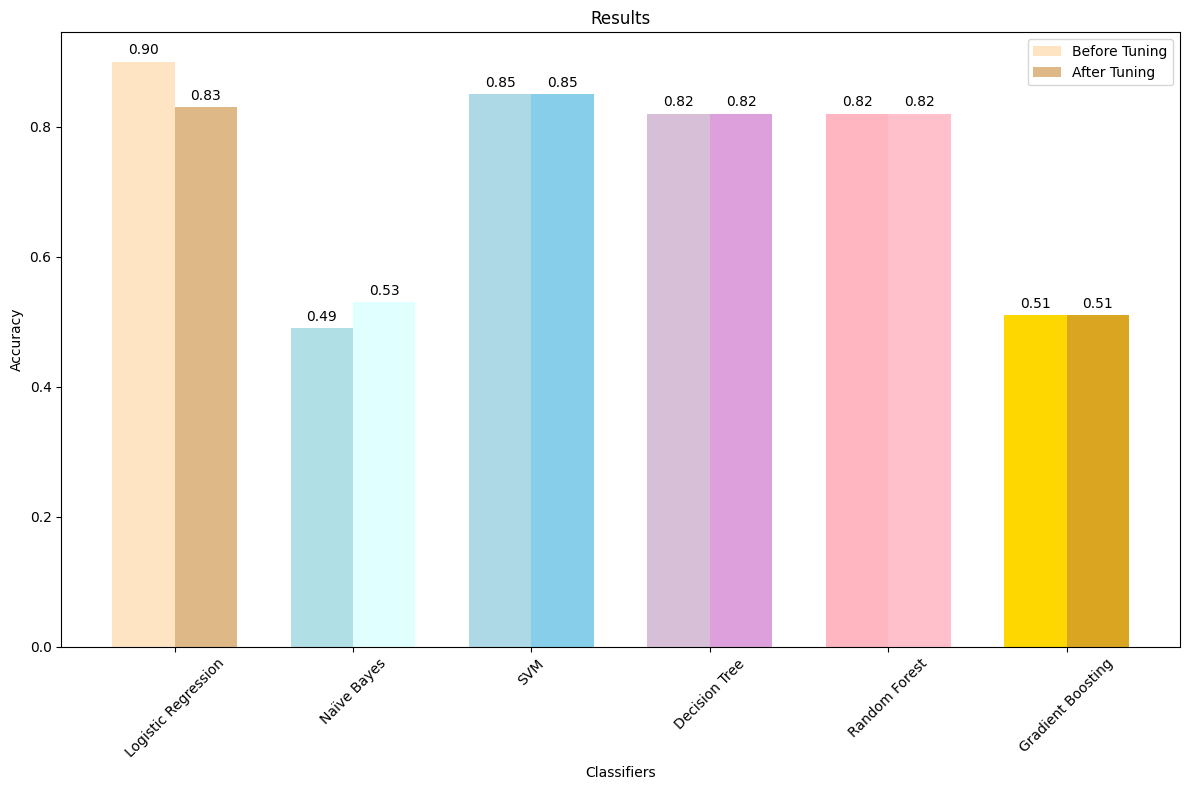

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Data
classifiers = [
    'Logistic Regression', 'Naïve Bayes', 'SVM',
    'Decision Tree', 'Random Forest', 'Gradient Boosting'
]
before_tuning = [0.90, 0.49, 0.85, 0.82, 0.82, 0.51]
after_tuning = [0.83, 0.53, 0.85, 0.82, 0.82, 0.51]  # Replace None with 0 or another placeholder

# Define bar width
bar_width = 0.35
index = np.arange(len(classifiers))

# Colors for each classifier
colors_before = ['bisque', 'powderblue', 'lightblue', 'thistle', 'lightpink', 'gold']
colors_after = ['burlywood', 'lightcyan', 'skyblue', 'plum', 'pink', 'goldenrod']

# Plot
fig, ax = plt.subplots(figsize=(12, 8))

# Plot before tuning
bars_before = ax.bar(index, before_tuning, bar_width, color=colors_before, label='Before Tuning')

# Plot after tuning
bars_after = ax.bar(index + bar_width, after_tuning, bar_width, color=colors_after, label='After Tuning')

# Add titles and labels
ax.set_xlabel('Classifiers')
ax.set_ylabel('Accuracy')
ax.set_title('Results')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(classifiers, rotation=45)
ax.legend()

# Add value labels on bars
def add_labels(bars, ax):
    for bar in bars:
        height = bar.get_height()
        if not np.isnan(height):  # Check if the height is not NaN
            ax.annotate(f'{height:.2f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

add_labels(bars_before, ax)
add_labels(bars_after, ax)

plt.tight_layout()
plt.show()

